In [ ]:
# === Cell 1: Install & Imports ===
# (Colab already has most libs; uncomment install lines if needed)
# !pip install numpy pandas matplotlib scikit-learn torch statsmodels prophet --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import json
from pathlib import Path
import datetime
import warnings
warnings.filterwarnings("ignore")

# Path to the uploaded CSV in Colab (change if you upload differently)
# If you upload via Colab's file UI, click "Files" then right-click the file -> copy path.
DATA_CSV_PATH = "/content/temperature_portland.csv"  # <- keep or update this path
OUT_DIR = "/content/processed_portland"               # where processed windows will be saved
os.makedirs(OUT_DIR, exist_ok=True)

print("Using dataset:", DATA_CSV_PATH)
print("Output directory:", OUT_DIR)


Using dataset: /content/temperature_portland.csv
Output directory: /content/processed_portland


In [ ]:
# === Cell 2: Load CSV and detect columns ===

df = pd.read_csv(DATA_CSV_PATH)
print("Raw columns:", list(df.columns))
display(df.head(8))

# Heuristics to find datetime and temperature column
datetime_col = None
temp_col = None

for c in df.columns:
    lname = c.lower()
    if 'date' in lname or 'time' in lname or 'timestamp' in lname:
        datetime_col = c
        break

# If none found, assume first column is datetime
if datetime_col is None:
    datetime_col = df.columns[0]
    print(f"No explicit date/time column found: using first column '{datetime_col}' as datetime")

# Temperature column heuristics
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in df.columns:
    if 'temp' in c.lower() or 'temperature' in c.lower():
        temp_col = c
        break
if temp_col is None:
    if len(numeric_cols) > 0:
        temp_col = numeric_cols[0]
        print(f"No 'temp' column found; using first numeric column '{temp_col}'")
    else:
        raise ValueError("No numeric column found for temperature. Please check the CSV.")

print("Datetime column:", datetime_col)
print("Temperature column:", temp_col)

# Parse datetime column
df[datetime_col] = pd.to_datetime(df[datetime_col], infer_datetime_format=True, errors='coerce')
n_missing_dt = df[datetime_col].isna().sum()
print("Datetime parse NA count:", n_missing_dt)
if n_missing_dt > 0:
    display(df[df[datetime_col].isna()].head())

# Set index
df = df.set_index(datetime_col).sort_index()
df = df[[temp_col]].rename(columns={temp_col: "temperature"})
print("Data range:", df.index.min(), "to", df.index.max())
print("Shape:", df.shape)
display(df.head())


Raw columns: ['datetime', 'Portland']


,datetime,Portland
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,282.080000
2,2012-10-01 14:00:00,282.083252
3,2012-10-01 15:00:00,282.091866
4,2012-10-01 16:00:00,282.100481
5,2012-10-01 17:00:00,282.109095
6,2012-10-01 18:00:00,282.117710
7,2012-10-01 19:00:00,282.126324


No 'temp' column found; using first numeric column 'Portland'
Datetime column: datetime
Temperature column: Portland
Datetime parse NA count: 0
Data range: 2012-10-01 12:00:00 to 2017-11-30 00:00:00
Shape: (45253, 1)


,temperature
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,282.080000
2012-10-01 14:00:00,282.083252
2012-10-01 15:00:00,282.091866
2012-10-01 16:00:00,282.100481


Inferred frequency: h
Missing after hourly resample: 1
Interpolated missing values and filled ends. Missing now: 0


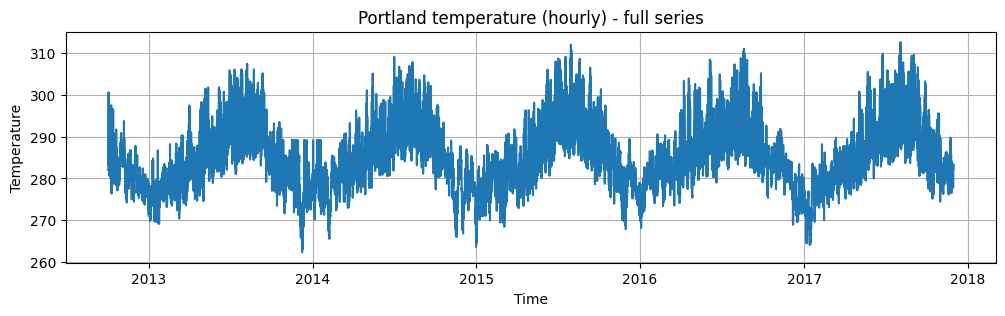

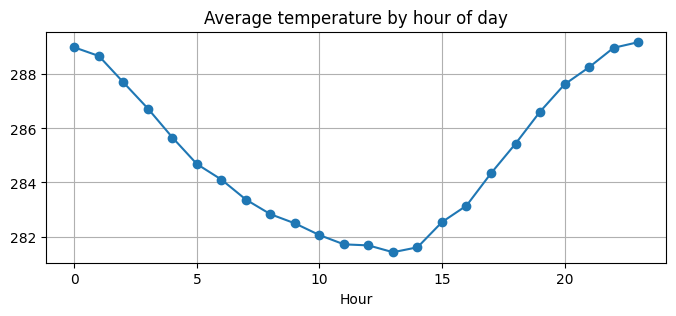

In [ ]:
# === Cell 3: Check regularity and fill/resample to hourly ===

# Check inferred freq
inferred = df.index.inferred_freq
print("Inferred frequency:", inferred)

# Resample to hourly (mean). This ensures clean hourly-indexed time series.
ts = df['temperature'].resample('H').mean()
n_missing = ts.isna().sum()
print("Missing after hourly resample:", n_missing)

# If missing values exist, impute by linear interpolation (sensible for temperature)
if n_missing > 0:
    ts_interpolated = ts.interpolate(method='time')  # time-aware linear interpolation
    # still might have NaN at ends; forward/backward fill those
    ts_interpolated = ts_interpolated.fillna(method='ffill').fillna(method='bfill')
    ts = ts_interpolated
    print("Interpolated missing values and filled ends. Missing now:", ts.isna().sum())

# Quick plot of full series and hour-of-day average
plt.figure(figsize=(12,3))
plt.plot(ts)
plt.title("Portland temperature (hourly) - full series")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.show()

# Hour-of-day pattern
hourly_mean = ts.groupby(ts.index.hour).mean()
plt.figure(figsize=(8,3))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.title("Average temperature by hour of day")
plt.xlabel("Hour")
plt.grid(True)
plt.show()


In [ ]:
# === Cell 4: Time-based Train/Validation/Test split ===

# Convert index to DatetimeIndex if not already
ts = ts.sort_index()
start, end = ts.index.min(), ts.index.max()
total_hours = len(ts)
print("Total hours:", total_hours, "from", start, "to", end)

# Use ratio split 70% train, 10% val, 20% test (time order)
n = total_hours
n_train = int(0.70 * n)
n_val = int(0.10 * n)
n_test = n - n_train - n_val

train_ts = ts.iloc[:n_train]
val_ts = ts.iloc[n_train:n_train+n_val]
test_ts = ts.iloc[n_train+n_val:]

print("Train/Val/Test sizes:", len(train_ts), len(val_ts), len(test_ts))
print("Train range:", train_ts.index.min(), "to", train_ts.index.max())
print("Val range:", val_ts.index.min(), "to", val_ts.index.max())
print("Test range:", test_ts.index.min(), "to", test_ts.index.max())


Total hours: 45253 from 2012-10-01 12:00:00 to 2017-11-30 00:00:00
Train/Val/Test sizes: 31677 4525 9051
Train range: 2012-10-01 12:00:00 to 2016-05-13 08:00:00
Val range: 2016-05-13 09:00:00 to 2016-11-17 21:00:00
Test range: 2016-11-17 22:00:00 to 2017-11-30 00:00:00


In [ ]:
# === Cell 5: Fit scaler on train and apply to all splits ===

scaler = StandardScaler()   # you can change to MinMaxScaler if you prefer
train_vals = train_ts.values.reshape(-1,1)
scaler.fit(train_vals)

# Apply
train_scaled = scaler.transform(train_ts.values.reshape(-1,1)).flatten()
val_scaled = scaler.transform(val_ts.values.reshape(-1,1)).flatten()
test_scaled = scaler.transform(test_ts.values.reshape(-1,1)).flatten()

# Save scaler parameters to disk for later inverse transform
scaler_params = {"mean": float(scaler.mean_[0]), "scale": float(scaler.scale_[0])}
with open(os.path.join(OUT_DIR, "scaler_params.json"), "w") as f:
    json.dump(scaler_params, f)
print("Saved scaler params:", scaler_params)


Saved scaler params: {'mean': 284.45095538942246, 'scale': 7.307799448736497}


In [ ]:
# === Cell 6: Windowing function and generate datasets ===

def create_windows(series, input_width, horizon):
    """
    series: 1D numpy array (scaled)
    input_width: number of historic time steps used as input
    horizon: number of steps to predict (forecast horizon)
    Returns X (samples, input_width), Y (samples, horizon)
    """
    X, Y = [], []
    N = len(series)
    # create pairs where input is [t-input_width : t) and output is [t : t+horizon)
    for t in range(input_width, N - horizon + 1):
        x = series[t-input_width:t]
        y = series[t:t+horizon]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

# Settings
WINDOW_SIZES = [24, 48, 168, 336, 720]   # input windows (hours)
HORIZON = 24                             # forecast horizon (hours)

# Build windows for train/val/test for each window size; save as npz
for W in WINDOW_SIZES:
    print(f"Generating windows for W={W}, H={HORIZON}")
    X_train, Y_train = create_windows(train_scaled, W, HORIZON)
    X_val, Y_val = create_windows(np.concatenate([train_scaled[-W:], val_scaled]), W, HORIZON)  # allow val windows overlapping end of train
    X_test, Y_test = create_windows(np.concatenate([val_scaled[-W:], test_scaled]), W, HORIZON)  # allow test windows overlapping val

    # Save
    out_file = os.path.join(OUT_DIR, f"windows_W{W}_H{HORIZON}.npz")
    np.savez_compressed(out_file,
                        X_train=X_train, Y_train=Y_train,
                        X_val=X_val, Y_val=Y_val,
                        X_test=X_test, Y_test=Y_test)
    print("Saved:", out_file, "Shapes ->",
          "X_train", X_train.shape, "Y_train", Y_train.shape,
          "X_val", X_val.shape, "X_test", X_test.shape)


Generating windows for W=24, H=24
Saved: /content/processed_portland/windows_W24_H24.npz Shapes -> X_train (31630, 24) Y_train (31630, 24) X_val (4502, 24) X_test (9028, 24)
Generating windows for W=48, H=24
Saved: /content/processed_portland/windows_W48_H24.npz Shapes -> X_train (31606, 48) Y_train (31606, 24) X_val (4502, 48) X_test (9028, 48)
Generating windows for W=168, H=24
Saved: /content/processed_portland/windows_W168_H24.npz Shapes -> X_train (31486, 168) Y_train (31486, 24) X_val (4502, 168) X_test (9028, 168)
Generating windows for W=336, H=24
Saved: /content/processed_portland/windows_W336_H24.npz Shapes -> X_train (31318, 336) Y_train (31318, 24) X_val (4502, 336) X_test (9028, 336)
Generating windows for W=720, H=24
Saved: /content/processed_portland/windows_W720_H24.npz Shapes -> X_train (30934, 720) Y_train (30934, 24) X_val (4502, 720) X_test (9028, 720)


windows_W168_H24.npz X_train (31486, 168) Y_train (31486, 24) X_val (4502, 168) X_test (9028, 168)
windows_W24_H24.npz X_train (31630, 24) Y_train (31630, 24) X_val (4502, 24) X_test (9028, 24)
windows_W336_H24.npz X_train (31318, 336) Y_train (31318, 24) X_val (4502, 336) X_test (9028, 336)
windows_W48_H24.npz X_train (31606, 48) Y_train (31606, 24) X_val (4502, 48) X_test (9028, 48)
windows_W720_H24.npz X_train (30934, 720) Y_train (30934, 24) X_val (4502, 720) X_test (9028, 720)


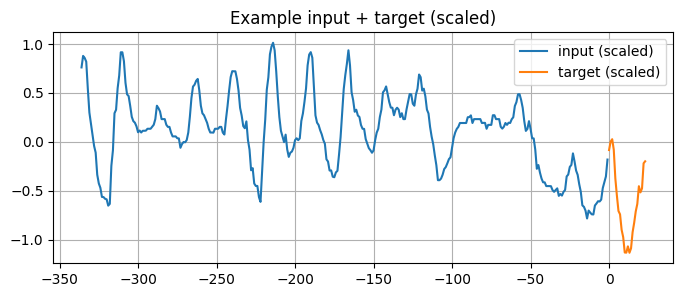

In [ ]:
# === Cell 7: Quick stats and sample visualizations ===
import glob
for file in sorted(glob.glob(os.path.join(OUT_DIR, "windows_*.npz"))):
    data = np.load(file)
    print(Path(file).name,
          "X_train", data['X_train'].shape,
          "Y_train", data['Y_train'].shape,
          "X_val", data['X_val'].shape,
          "X_test", data['X_test'].shape)

# Visualize one sample (example)
sample = np.load(sorted(glob.glob(os.path.join(OUT_DIR, "windows_*.npz")))[2])  # arbitrary choice
x0 = sample['X_test'][0]
y0 = sample['Y_test'][0]

plt.figure(figsize=(8,3))
plt.plot(range(-len(x0), 0), x0, label='input (scaled)')
plt.plot(range(0, len(y0)), y0, label='target (scaled)')
plt.legend()
plt.title("Example input + target (scaled)")
plt.grid(True)
plt.show()


In [ ]:
# === Cell 8: Metric helpers and inverse scaling ===
import math
def inverse_scale(scaled_array):
    # load scaler params
    with open(os.path.join(OUT_DIR, "scaler_params.json"), "r") as f:
        p = json.load(f)
    return scaled_array * p["scale"] + p["mean"]

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred)**2))

def MAPE(y_true, y_pred):
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

# Example usage (after model predictions)
# y_true_inv = inverse_scale(y_true_scaled)
# y_pred_inv = inverse_scale(y_pred_scaled)
# print(MAE(y_true_inv, y_pred_inv), RMSE(y_true_inv, y_pred_inv), MAPE(y_true_inv, y_pred_inv))


# Training

In [ ]:
# === Cell A: Install & imports ===
!pip install prophet --quiet        # installs prophet (may take ~1-2 min)
!pip install torch torchvision --quiet

import os, math, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from prophet import Prophet
import statsmodels.api as sm
print("Libraries loaded. PyTorch version:", torch.__version__)


Libraries loaded. PyTorch version: 2.9.0+cu126


In [ ]:
# === Cell B: Settings & helper functions ===
DATA_CSV_PATH = "/content/temperature_portland.csv"    # keep/update if needed
OUT_DIR = "/content/processed_portland"                # same as preprocessing output
WINDOW_SIZES = [24, 48, 168, 336, 720]
HORIZON = 24
RESULTS_DIR = "/content/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load scaler params (generated by preprocessing)
scaler_params_path = os.path.join(OUT_DIR, "scaler_params.json")
with open(scaler_params_path, "r") as f:
    scaler_params = json.load(f)
SCALE_MEAN = scaler_params["mean"]
SCALE_SCALE = scaler_params["scale"]

def inverse_scale(arr):
    return arr * SCALE_SCALE + SCALE_MEAN

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def RMSE(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred)**2))

def MAPE(y_true, y_pred):
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def load_window_npz(W):
    path = os.path.join(OUT_DIR, f"windows_W{W}_H{HORIZON}.npz")
    data = np.load(path)
    return data

def to_torch_loader(X, Y, batch_size=64, shuffle=True):
    tX = torch.from_numpy(X).float()
    tY = torch.from_numpy(Y).float()
    ds = TensorDataset(tX, tY)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


Device: cuda


# ARIMA

# DL

In [ ]:
# === Cell E: Model definitions ===
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, horizon=HORIZON):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, horizon)
    def forward(self, x):
        # x: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        out, (hn, cn) = self.lstm(x)
        # take last hidden state
        last = out[:, -1, :]   # (batch, hidden)
        out = self.fc(last)    # (batch, horizon)
        return out

class GRUForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, horizon=HORIZON):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, horizon)
    def forward(self, x):
        x = x.unsqueeze(-1)
        out, hn = self.gru(x)
        last = out[:, -1, :]
        out = self.fc(last)
        return out

class TransformerForecaster(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2, horizon=HORIZON):
        super().__init__()
        self.seq_len = seq_len
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, horizon)
    def forward(self, x):
        # x: (batch, seq_len)
        x = x.unsqueeze(-1)                 # (batch, seq_len, 1)
        x = self.input_proj(x)              # (batch, seq_len, d_model)
        # positional encoding: add simple positional indices
        pos = torch.arange(self.seq_len, device=x.device).float().unsqueeze(0).unsqueeze(-1) / self.seq_len
        x = x + pos
        enc = self.encoder(x)               # (batch, seq_len, d_model)
        last = enc[:, -1, :]
        out = self.fc(last)
        return out


In [ ]:
# === Cell F: Training & evaluation utilities ===
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, model_name="model"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    best_state = None
    for ep in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
        # val
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())
        avg_train = np.mean(train_losses) if train_losses else 0
        avg_val = np.mean(val_losses) if val_losses else 0
        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
        if ep % max(1, epochs//5) == 0 or ep==1:
            print(f"{model_name} Epoch {ep}/{epochs} train_loss {avg_train:.6f} val_loss {avg_val:.6f}")
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def predict_numpy(model, X):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), 256):
            xb = torch.from_numpy(X[i:i+256]).float().to(device)
            p = model(xb).cpu().numpy()
            preds.append(p)
    preds = np.vstack(preds)
    return preds


In [ ]:
# === Cell G: Train/eval LSTM, GRU, Transformer across windows ===
deep_results = {"LSTM": {}, "GRU": {}, "Transformer": {}}

for W in WINDOW_SIZES:
    print("======== Window:", W, "========")
    data = load_window_npz(W)
    X_train = data['X_train']; Y_train = data['Y_train']
    X_val = data['X_val']; Y_val = data['Y_val']
    X_test = data['X_test']; Y_test = data['Y_test']

    # create loaders
    batch_size = 64
    train_loader = to_torch_loader(X_train, Y_train, batch_size=batch_size, shuffle=True)
    val_loader = to_torch_loader(X_val, Y_val, batch_size=batch_size, shuffle=False)

    # LSTM
    torch.manual_seed(0)
    lstm = LSTMForecaster(input_dim=1, hidden_dim=64, num_layers=2, horizon=HORIZON)
    lstm = train_model(lstm, train_loader, val_loader, epochs=10, lr=1e-3, model_name=f"LSTM_W{W}")
    preds_lstm = predict_numpy(lstm, X_test)
    preds_lstm_inv = inverse_scale(preds_lstm)
    y_true_inv = inverse_scale(Y_test)
    deep_results["LSTM"][W] = {
        "mae": MAE(y_true_inv.flatten(), preds_lstm_inv.flatten()),
        "rmse": RMSE(y_true_inv.flatten(), preds_lstm_inv.flatten()),
        "mape": MAPE(y_true_inv.flatten(), preds_lstm_inv.flatten())
    }
    print(" LSTM metrics:", deep_results["LSTM"][W])

    # GRU
    torch.manual_seed(0)
    gru = GRUForecaster(input_dim=1, hidden_dim=64, num_layers=2, horizon=HORIZON)
    gru = train_model(gru, train_loader, val_loader, epochs=10, lr=1e-3, model_name=f"GRU_W{W}")
    preds_gru = predict_numpy(gru, X_test)
    preds_gru_inv = inverse_scale(preds_gru)
    deep_results["GRU"][W] = {
        "mae": MAE(y_true_inv.flatten(), preds_gru_inv.flatten()),
        "rmse": RMSE(y_true_inv.flatten(), preds_gru_inv.flatten()),
        "mape": MAPE(y_true_inv.flatten(), preds_gru_inv.flatten())
    }
    print(" GRU metrics:", deep_results["GRU"][W])

    # Transformer
    torch.manual_seed(0)
    transformer = TransformerForecaster(seq_len=W, d_model=64, nhead=4, num_layers=2, horizon=HORIZON)
    transformer = train_model(transformer, train_loader, val_loader, epochs=10, lr=1e-3, model_name=f"Transformer_W{W}")
    preds_tr = predict_numpy(transformer, X_test)
    preds_tr_inv = inverse_scale(preds_tr)
    deep_results["Transformer"][W] = {
        "mae": MAE(y_true_inv.flatten(), preds_tr_inv.flatten()),
        "rmse": RMSE(y_true_inv.flatten(), preds_tr_inv.flatten()),
        "mape": MAPE(y_true_inv.flatten(), preds_tr_inv.flatten())
    }
    print(" Transformer metrics:", deep_results["Transformer"][W])

    # optional: save predictions to disk per model
    np.savez_compressed(os.path.join(RESULTS_DIR, f"preds_W{W}.npz"),
                        y_true=y_true_inv, lstm=preds_lstm_inv, gru=preds_gru_inv, transformer=preds_tr_inv)

# Save deep results
with open(os.path.join(RESULTS_DIR, "deep_results.json"), "w") as f:
    json.dump(deep_results, f)
print("Deep models done.")


======== Window: 24 ========
LSTM_W24 Epoch 1/10 train_loss 0.235420 val_loss 0.146307
LSTM_W24 Epoch 2/10 train_loss 0.129401 val_loss 0.128795
LSTM_W24 Epoch 4/10 train_loss 0.120068 val_loss 0.126440
LSTM_W24 Epoch 6/10 train_loss 0.115654 val_loss 0.127704
LSTM_W24 Epoch 8/10 train_loss 0.111894 val_loss 0.119054
LSTM_W24 Epoch 10/10 train_loss 0.109950 val_loss 0.116247
 LSTM metrics: {'mae': np.float64(1.8060258234572109), 'rmse': 2.4235495956944653, 'mape': np.float64(0.6328654928978945)}
GRU_W24 Epoch 1/10 train_loss 0.204462 val_loss 0.144894
GRU_W24 Epoch 2/10 train_loss 0.125457 val_loss 0.135072
GRU_W24 Epoch 4/10 train_loss 0.118753 val_loss 0.122483
GRU_W24 Epoch 6/10 train_loss 0.114301 val_loss 0.123916
GRU_W24 Epoch 8/10 train_loss 0.111144 val_loss 0.117801
GRU_W24 Epoch 10/10 train_loss 0.109405 val_loss 0.120308
 GRU metrics: {'mae': np.float64(1.813327667823436), 'rmse': 2.42813116748724, 'mape': np.float64(0.635002926497999)}
Transformer_W24 Epoch 1/10 train_loss 

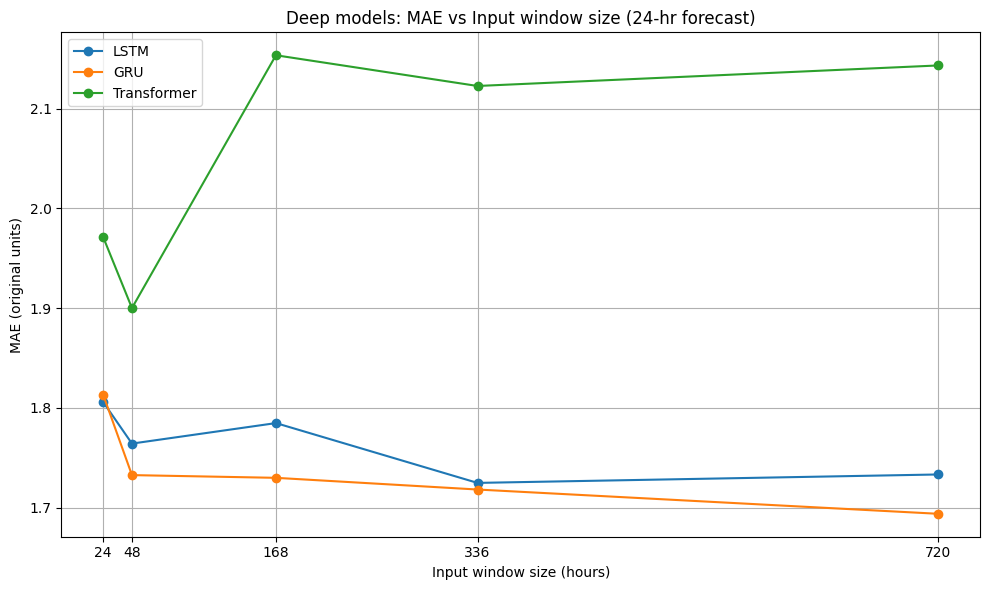

Saved figure to /content/model_results/deep_models_mae_vs_window.png

MAE (rows = window size):


,LSTM,GRU,Transformer
24,1.806026,1.813328,1.971265
48,1.764304,1.732724,1.900096
168,1.784850,1.729997,2.153417
336,1.724914,1.718278,2.122636
720,1.733363,1.693957,2.143205



RMSE (rows = window size):


,LSTM,GRU,Transformer
24,2.423550,2.428131,2.620717
48,2.362896,2.329937,2.528186
168,2.408019,2.333395,2.842209
336,2.327498,2.315412,2.802952
720,2.351153,2.298780,2.817783



MAPE % (rows = window size):


,LSTM,GRU,Transformer
24,0.632865,0.635003,0.691323
48,0.618084,0.607292,0.665183
168,0.624336,0.606785,0.753988
336,0.604180,0.602478,0.743696
720,0.607272,0.593014,0.750494


Saved MAE/RMSE/MAPE tables to /content/model_results


In [ ]:
# === Plot Deep-Learning results (LSTM, GRU, Transformer) ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = "/content/model_results"
DEEP_PATH = os.path.join(RESULTS_DIR, "deep_results.json")
WINDOW_SIZES = [24, 48, 168, 336, 720]

if not os.path.exists(DEEP_PATH):
    raise FileNotFoundError(f"Deep results not found at {DEEP_PATH}. Run the DL training cells first.")

# load deep results
with open(DEEP_PATH, "r") as f:
    deep = json.load(f)

# models we expect (but adapt if names differ)
model_names = [k for k in deep.keys()]

# prepare metric tables
metrics = {"MAE": {}, "RMSE": {}, "MAPE": {}}
for m in model_names:
    metrics["MAE"][m] = []
    metrics["RMSE"][m] = []
    metrics["MAPE"][m] = []
    for W in WINDOW_SIZES:
        # deep json might have string keys or int keys
        entry = None
        if str(W) in deep[m]:
            entry = deep[m][str(W)]
        elif W in deep[m]:
            entry = deep[m][W]
        # If absent or null, set NaN
        if entry is None or entry.get("mae") is None:
            metrics["MAE"][m].append(np.nan)
            metrics["RMSE"][m].append(np.nan)
            metrics["MAPE"][m].append(np.nan)
        else:
            metrics["MAE"][m].append(entry.get("mae", np.nan))
            metrics["RMSE"][m].append(entry.get("rmse", np.nan))
            metrics["MAPE"][m].append(entry.get("mape", np.nan))

# Plot MAE vs Window size
plt.figure(figsize=(10,6))
for m in model_names:
    plt.plot(WINDOW_SIZES, metrics["MAE"][m], marker='o', label=m)
plt.xlabel("Input window size (hours)")
plt.xticks(WINDOW_SIZES)
plt.ylabel("MAE (original units)")
plt.title("Deep models: MAE vs Input window size (24-hr forecast)")
plt.grid(True)
plt.legend()
plt.tight_layout()
out_fig = os.path.join(RESULTS_DIR, "deep_models_mae_vs_window.png")
plt.savefig(out_fig, dpi=200)
plt.show()
print(f"Saved figure to {out_fig}")

# Also show table of MAE / RMSE / MAPE
df_mae = pd.DataFrame({m: metrics["MAE"][m] for m in model_names}, index=WINDOW_SIZES)
df_rmse = pd.DataFrame({m: metrics["RMSE"][m] for m in model_names}, index=WINDOW_SIZES)
df_mape = pd.DataFrame({m: metrics["MAPE"][m] for m in model_names}, index=WINDOW_SIZES)

print("\nMAE (rows = window size):")
display(df_mae)
print("\nRMSE (rows = window size):")
display(df_rmse)
print("\nMAPE % (rows = window size):")
display(df_mape)

# Save CSV tables for later
df_mae.to_csv(os.path.join(RESULTS_DIR, "deep_mae_table.csv"))
df_rmse.to_csv(os.path.join(RESULTS_DIR, "deep_rmse_table.csv"))
df_mape.to_csv(os.path.join(RESULTS_DIR, "deep_mape_table.csv"))
print("Saved MAE/RMSE/MAPE tables to", RESULTS_DIR)


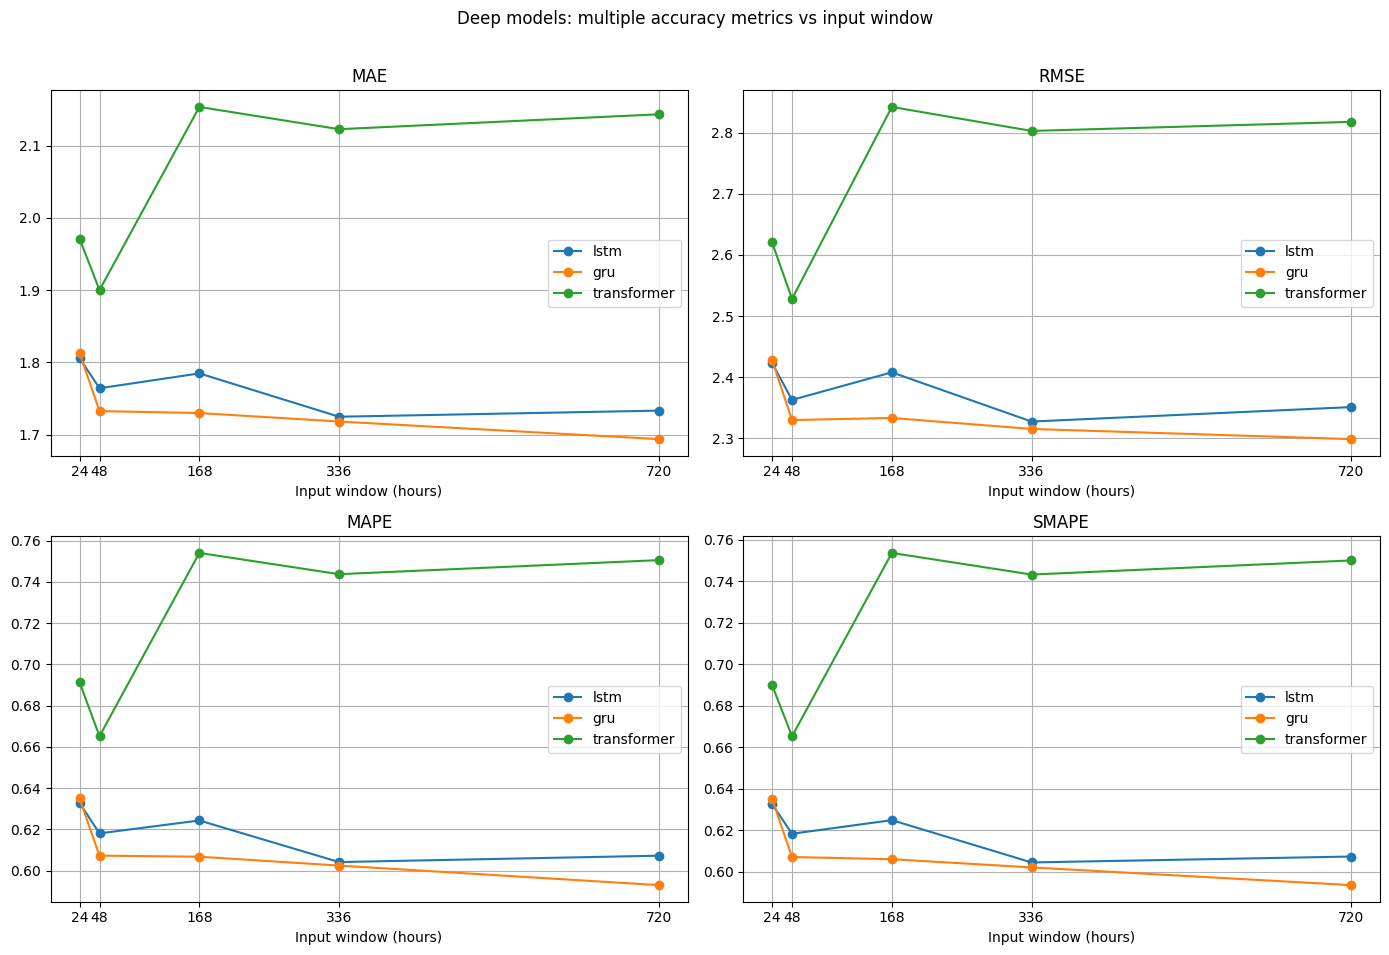

Saved figure to: /content/model_results/deep_full_metrics.png
Saved full metrics CSV to: /content/model_results/deep_full_metrics.csv

MAE table:


,lstm,gru,transformer
24,1.806026,1.813328,1.971265
48,1.764304,1.732724,1.900096
168,1.784850,1.729997,2.153417
336,1.724914,1.718278,2.122636
720,1.733363,1.693957,2.143205



RMSE table:


,lstm,gru,transformer
24,2.423550,2.428131,2.620717
48,2.362896,2.329937,2.528186
168,2.408019,2.333395,2.842209
336,2.327498,2.315412,2.802952
720,2.351153,2.298780,2.817783



MAPE table:


,lstm,gru,transformer
24,0.632865,0.635003,0.691323
48,0.618084,0.607292,0.665183
168,0.624336,0.606785,0.753988
336,0.604180,0.602478,0.743696
720,0.607272,0.593014,0.750494



SMAPE table:


,lstm,gru,transformer
24,0.632577,0.635098,0.689947
48,0.618198,0.606988,0.665206
168,0.624761,0.605935,0.753601
336,0.604369,0.601972,0.743179
720,0.607222,0.593443,0.749988



R2 table:


,lstm,gru,transformer
24,0.907041,0.906690,0.891301
48,0.911636,0.914084,0.898841
168,0.908229,0.913829,0.872151
336,0.914264,0.915152,0.875658
720,0.912512,0.916366,0.874339



MBE table:


,lstm,gru,transformer
24,0.081654,-0.077238,0.508148
48,-0.071085,0.095067,-0.056968
168,-0.193787,0.371382,0.067183
336,-0.121275,0.229740,0.191283
720,0.002280,-0.201882,0.138987



Done. If any model keys differ (e.g., capitalized names), tell me and I will adapt the loader to match them.


In [ ]:
# === Compute & Plot Extended Deep-model Metrics ===
# Original uploaded CSV path (local)
CSV_PATH = "/mnt/data/temperature_portland.csv"   # <-- provided for reference / tool use

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
RESULTS_DIR = "/content/model_results"
WINDOW_SIZES = [24, 48, 168, 336, 720]

# Metric helpers
def MAE(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def RMSE(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def MAPE(y_true, y_pred):
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
def SMAPE(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1e-6, denom)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)
def MBE(y_true, y_pred): return np.mean(y_pred - y_true)

# models expected in the preds files (keys)
dl_model_keys = ["lstm", "gru", "transformer"]   # adapt if your keys differ

# storage
metrics = {m: {"MAE": [], "RMSE": [], "MAPE": [], "SMAPE": [], "R2": [], "MBE": []} for m in dl_model_keys}
available_windows = []

for W in WINDOW_SIZES:
    pred_file = os.path.join(RESULTS_DIR, f"preds_W{W}.npz")
    if not os.path.exists(pred_file):
        print(f"Warning: predictions file not found for W={W}: {pred_file} (skipping W)")
        continue
    available_windows.append(W)
    data = np.load(pred_file, allow_pickle=True)
    # Try to detect y_true and model arrays
    # Keys might be: 'y_true', 'lstm', 'gru', 'transformer' (as saved earlier)
    if 'y_true' in data:
        y_true = data['y_true']
    elif 'y' in data:
        y_true = data['y']
    else:
        # try first array that looks like ground truth
        # find array with name containing 'true' or 'y'
        y_true = None
        for k in data:
            if 'true' in k or k in ['y_true', 'y', 'target']:
                y_true = data[k]
                break
        if y_true is None:
            # fallback: take the first array
            y_true = data[list(data.files)[0]]

    # ensure y_true is 2D (samples, horizon)
    y_true = np.array(y_true)
    if y_true.ndim == 1:
        # possibly flattened; try to reshape based on horizon 24 if divisible
        if y_true.size % 24 == 0:
            y_true = y_true.reshape(-1, 24)
        else:
            y_true = y_true.reshape(-1, 1)

    for m in dl_model_keys:
        if m in data.files:
            y_pred = np.array(data[m])
            # reshape if needed
            if y_pred.ndim == 1:
                if y_pred.size == y_true.size:
                    y_pred = y_pred.reshape(y_true.shape)
                elif y_pred.size % 24 == 0:
                    y_pred = y_pred.reshape(-1, 24)
                else:
                    # fallback: make same shape as y_true by trunc/pad
                    y_pred = y_pred.flatten()
                    if y_pred.size < y_true.size:
                        pad = np.full(y_true.size - y_pred.size, np.nan)
                        y_pred = np.concatenate([y_pred, pad])
                    y_pred = y_pred.reshape(y_true.shape)
            # Now compute metrics using flattened arrays, but ignoring NaNs
            y_true_flat = y_true.flatten()
            y_pred_flat = y_pred.flatten()
            mask = ~np.isnan(y_pred_flat) & ~np.isnan(y_true_flat)
            if mask.sum() == 0:
                # no valid preds
                metrics[m]["MAE"].append(np.nan)
                metrics[m]["RMSE"].append(np.nan)
                metrics[m]["MAPE"].append(np.nan)
                metrics[m]["SMAPE"].append(np.nan)
                metrics[m]["R2"].append(np.nan)
                metrics[m]["MBE"].append(np.nan)
                continue
            yt = y_true_flat[mask]
            yp = y_pred_flat[mask]
            metrics[m]["MAE"].append(MAE(yt, yp))
            metrics[m]["RMSE"].append(RMSE(yt, yp))
            metrics[m]["MAPE"].append(MAPE(yt, yp))
            metrics[m]["SMAPE"].append(SMAPE(yt, yp))
            try:
                r2 = r2_score(yt, yp)
            except Exception:
                r2 = np.nan
            metrics[m]["R2"].append(r2)
            metrics[m]["MBE"].append(MBE(yt, yp))
        else:
            # model predictions missing for this W
            metrics[m]["MAE"].append(np.nan)
            metrics[m]["RMSE"].append(np.nan)
            metrics[m]["MAPE"].append(np.nan)
            metrics[m]["SMAPE"].append(np.nan)
            metrics[m]["R2"].append(np.nan)
            metrics[m]["MBE"].append(np.nan)

# Convert to DataFrames for display
# Use available_windows as index
index = available_windows
df_list = {}
for metric_name in ["MAE", "RMSE", "MAPE", "SMAPE", "R2", "MBE"]:
    df_list[metric_name] = pd.DataFrame(
        {m: metrics[m][metric_name] for m in dl_model_keys},
        index=index
    )

# Plot: MAE / RMSE / MAPE / SMAPE subplots
fig, axs = plt.subplots(2,2, figsize=(14,10))
axs = axs.flatten()
for ax, metric_name in zip(axs, ["MAE", "RMSE", "MAPE", "SMAPE"]):
    for m in dl_model_keys:
        ax.plot(index, df_list[metric_name][m], marker='o', label=m)
    ax.set_title(metric_name)
    ax.set_xlabel("Input window (hours)")
    ax.set_xticks(index)
    ax.grid(True)
    ax.legend()
plt.suptitle("Deep models: multiple accuracy metrics vs input window")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
out_fig = os.path.join(RESULTS_DIR, "deep_full_metrics.png")
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved figure to:", out_fig)

# Combine all metrics into a single multi-index dataframe and save CSV
rows = []
for W in index:
    for m in dl_model_keys:
        rows.append({
            "window": W,
            "model": m,
            "MAE": df_list["MAE"].loc[W, m],
            "RMSE": df_list["RMSE"].loc[W, m],
            "MAPE": df_list["MAPE"].loc[W, m],
            "SMAPE": df_list["SMAPE"].loc[W, m],
            "R2": df_list["R2"].loc[W, m],
            "MBE": df_list["MBE"].loc[W, m],
        })
df_results = pd.DataFrame(rows)
csv_out = os.path.join(RESULTS_DIR, "deep_full_metrics.csv")
df_results.to_csv(csv_out, index=False)
print("Saved full metrics CSV to:", csv_out)

# Display tables for quick inspection
print("\nMAE table:")
display(df_list["MAE"])
print("\nRMSE table:")
display(df_list["RMSE"])
print("\nMAPE table:")
display(df_list["MAPE"])
print("\nSMAPE table:")
display(df_list["SMAPE"])
print("\nR2 table:")
display(df_list["R2"])
print("\nMBE table:")
display(df_list["MBE"])

print("\nDone. If any model keys differ (e.g., capitalized names), tell me and I will adapt the loader to match them.")


In [ ]:
# === CLASSICAL PIPELINE: Cell 1 ===
!pip install -q statsmodels pmdarima

import pandas as pd
import numpy as np
import os, math, warnings
warnings.filterwarnings("ignore")

print("Packages loaded.")

CSV_PATH = "/content/temperature_portland.csv"    # your dataset
RESULTS_DIR = "/content/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Load CSV ---
df = pd.read_csv(CSV_PATH)

# detect datetime col
datetime_col = None
for c in df.columns:
    if "date" in c.lower() or "time" in c.lower():
        datetime_col = c
        break
if datetime_col is None:
    datetime_col = df.columns[0]

# detect temperature col
temp_col = None
for c in df.columns:
    if "temp" in c.lower():
        temp_col = c
        break
if temp_col is None:
    temp_col = df.select_dtypes(include="number").columns[0]

df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
df = df.set_index(datetime_col).sort_index()

# hourly sampling
ts = df[temp_col].resample("H").mean()
ts = ts.interpolate("time").fillna(method="ffill").fillna(method="bfill")

# ---- Train/Val/Test Split ----
n = len(ts)
n_train = int(0.70 * n)
n_val   = int(0.10 * n)
n_test  = n - n_train - n_val

train_ts = ts.iloc[:n_train]
val_ts   = ts.iloc[n_train:n_train+n_val]
test_ts  = ts.iloc[n_train+n_val:]

print("Train:", train_ts.index.min(), "->", train_ts.index.max())
print("Test :", test_ts.index.min(),  "->", test_ts.index.max(), "(n_test =", len(test_ts), ")")

# ---- Forecast horizon and coverage ----
HORIZON = 24
forecast_end = test_ts.index.max() + pd.Timedelta(hours=HORIZON-1)

WINDOW_SIZES = [24, 48, 168, 336, 720]

print("forecast_end =", forecast_end)
print("READY ✓")


Packages loaded.
Train: 2012-10-01 12:00:00 -> 2016-05-13 08:00:00
Test : 2016-11-17 22:00:00 -> 2017-11-30 00:00:00 (n_test = 9051 )
forecast_end = 2017-11-30 23:00:00
READY ✓


In [ ]:
# === CLASSICAL PIPELINE: Cell 2 — ARIMA ===
from statsmodels.tsa.arima.model import ARIMA

print("Fitting ARIMA... (2,0,2) baseline)")

try:
    arima_model = ARIMA(train_ts, order=(2,0,2))
    arima_fit = arima_model.fit()

    total_steps = int((forecast_end - train_ts.index.max()) / pd.Timedelta("1H"))
    arima_fc = arima_fit.get_forecast(steps=total_steps)

    arima_pred = pd.Series(
        arima_fc.predicted_mean.values,
        index=pd.date_range(
            start=train_ts.index.max() + pd.Timedelta("1H"),
            periods=total_steps,
            freq="H"
        )
    )
    print("ARIMA forecast length:", len(arima_pred))
except Exception as e:
    print("ARIMA failed:", e)
    arima_pred = None

print("ARIMA READY ✓")


Fitting ARIMA... (2,0,2) baseline)
ARIMA forecast length: 13599
ARIMA READY ✓


In [ ]:
# === CLASSICAL PIPELINE: Cell 3 — ETS ===
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print("Fitting ETS...")

try:
    ets_model = ExponentialSmoothing(
        train_ts,
        trend="add",
        seasonal="add",
        seasonal_periods=24*7     # weekly seasonality in hourly data
    )
    ets_fit = ets_model.fit()

    total_steps = int((forecast_end - train_ts.index.max()) / pd.Timedelta("1H"))
    ets_pred = ets_fit.forecast(total_steps)

    ets_pred.index = pd.date_range(
        start=train_ts.index.max() + pd.Timedelta("1H"),
        periods=total_steps,
        freq="H"
    )

    print("ETS forecast length:", len(ets_pred))

except Exception as e:
    print("ETS failed:", e)
    ets_pred = None

print("ETS READY ✓")


Fitting ETS...
ETS forecast length: 13599
ETS READY ✓


In [ ]:
# === CLASSICAL PIPELINE: Cell 4 — AutoARIMA (optional) ===
from pmdarima import auto_arima

print("Fitting AutoARIMA...")

try:
    auto_model = auto_arima(train_ts, seasonal=False, suppress_warnings=True)

    total_steps = int((forecast_end - train_ts.index.max()) / pd.Timedelta("1H"))
    auto_pred = auto_model.predict(total_steps)

    auto_pred = pd.Series(
        auto_pred,
        index=pd.date_range(
            start=train_ts.index.max() + pd.Timedelta("1H"),
            periods=total_steps,
            freq="H"
        )
    )

    print("AutoARIMA forecast length:", len(auto_pred))

except Exception as e:
    print("AutoARIMA failed:", e)
    auto_pred = None

print("AutoARIMA READY ✓")


Fitting AutoARIMA...
AutoARIMA forecast length: 13599
AutoARIMA READY ✓


In [ ]:
# === CLASSICAL PIPELINE: Cell 5 — Evaluate per window (ARIMA / ETS / AutoARIMA) ===

def evaluate_forecast(forecast_series, full_ts, test_idx, W_list):
    results = {}
    for W in W_list:
        y_true_all = []
        y_pred_all = []

        for t in test_idx:
            # ensure 24h horizon fits in test
            if t + pd.Timedelta("23H") > test_idx.max():
                continue
            # ensure W-hour history available
            if t - pd.Timedelta(hours=W) < full_ts.index.min():
                continue

            y_true = full_ts.loc[t : t + pd.Timedelta("23H")].values

            try:
                y_pred = forecast_series.loc[t : t + pd.Timedelta("23H")].values
            except:
                continue

            if len(y_pred) == 24:
                y_true_all.append(y_true)
                y_pred_all.append(y_pred)

        if len(y_true_all) == 0:
            results[str(W)] = {"mae": None, "rmse": None, "mape": None}
            continue

        y_true_all = np.vstack(y_true_all).flatten()
        y_pred_all = np.vstack(y_pred_all).flatten()

        mae = np.mean(np.abs(y_true_all - y_pred_all))
        rmse = np.sqrt(np.mean((y_true_all - y_pred_all)**2))
        mape = np.mean(np.abs((y_true_all - y_pred_all) /
                              np.maximum(np.abs(y_true_all), 1e-6))) * 100

        results[str(W)] = {
            "mae": float(mae),
            "rmse": float(rmse),
            "mape": float(mape)
        }
    return results


# Run evaluation
arima_results = evaluate_forecast(arima_pred, ts, test_ts.index, WINDOW_SIZES) if arima_pred is not None else {}
ets_results   = evaluate_forecast(ets_pred,   ts, test_ts.index, WINDOW_SIZES) if ets_pred   is not None else {}
auto_results  = evaluate_forecast(auto_pred,  ts, test_ts.index, WINDOW_SIZES) if auto_pred  is not None else {}

# Save JSONs (Deep Learning expects these exact file names)
import json
with open(os.path.join(RESULTS_DIR, "arima_results.json"), "w") as f:
    json.dump(arima_results, f)
with open(os.path.join(RESULTS_DIR, "ets_results.json"), "w") as f:
    json.dump(ets_results, f)
with open(os.path.join(RESULTS_DIR, "autoarima_results.json"), "w") as f:
    json.dump(auto_results, f)

print("\nSaved classical results JSON.")
print("ARIMA:", arima_results)
print("ETS:", ets_results)
print("AUTOARIMA:", auto_results)
print("CLASSICAL PIPELINE COMPLETE ✓")



Saved classical results JSON.
ARIMA: {'24': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '48': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '168': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '336': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '720': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}}
ETS: {'24': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '48': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '168': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '336': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '720': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}}
AUTOARIMA: {'24': {'mae': 8.859915500265794, 'rms

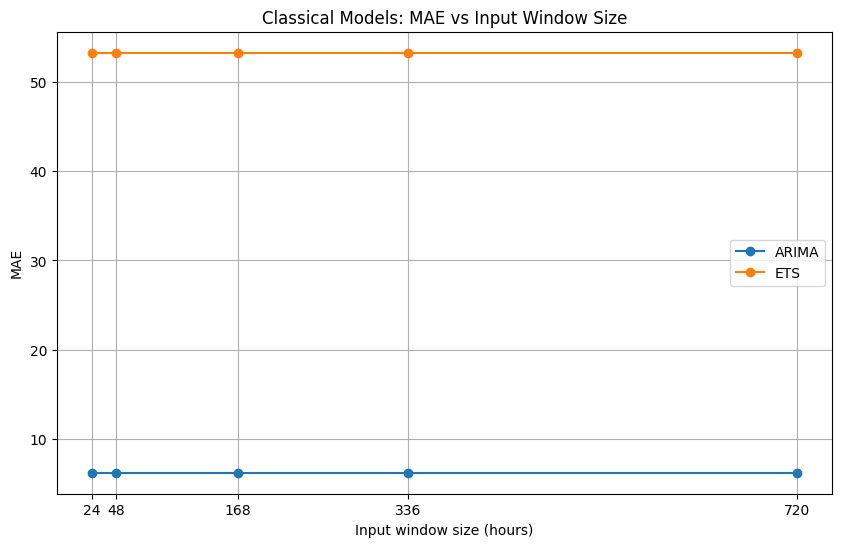

,ARIMA,ETS
24,6.272205,53.219884
48,6.272205,53.219884
168,6.272205,53.219884
336,6.272205,53.219884
720,6.272205,53.219884


In [ ]:
# === Plot ARIMA vs ETS (Classical Models Only) ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = "/content/model_results"
WINDOW_SIZES = [24, 48, 168, 336, 720]

# Load
with open(os.path.join(RESULTS_DIR, "arima_results.json")) as f:
    arima = json.load(f)

with open(os.path.join(RESULTS_DIR, "ets_results.json")) as f:
    ets = json.load(f)

models = ["ARIMA", "ETS"]
mae = {"ARIMA": [], "ETS": []}

for W in WINDOW_SIZES:
    key = str(W)
    # ARIMA
    if key in arima and arima[key]["mae"] is not None:
        mae["ARIMA"].append(arima[key]["mae"])
    else:
        mae["ARIMA"].append(np.nan)
    # ETS
    if key in ets and ets[key]["mae"] is not None:
        mae["ETS"].append(ets[key]["mae"])
    else:
        mae["ETS"].append(np.nan)

# Plot
plt.figure(figsize=(10,6))
plt.plot(WINDOW_SIZES, mae["ARIMA"], marker='o', label="ARIMA")
plt.plot(WINDOW_SIZES, mae["ETS"], marker='o', label="ETS")

plt.xlabel("Input window size (hours)")
plt.ylabel("MAE")
plt.title("Classical Models: MAE vs Input Window Size")
plt.xticks(WINDOW_SIZES)
plt.grid(True)
plt.legend()
plt.show()

# Table
pd.DataFrame(mae, index=WINDOW_SIZES)


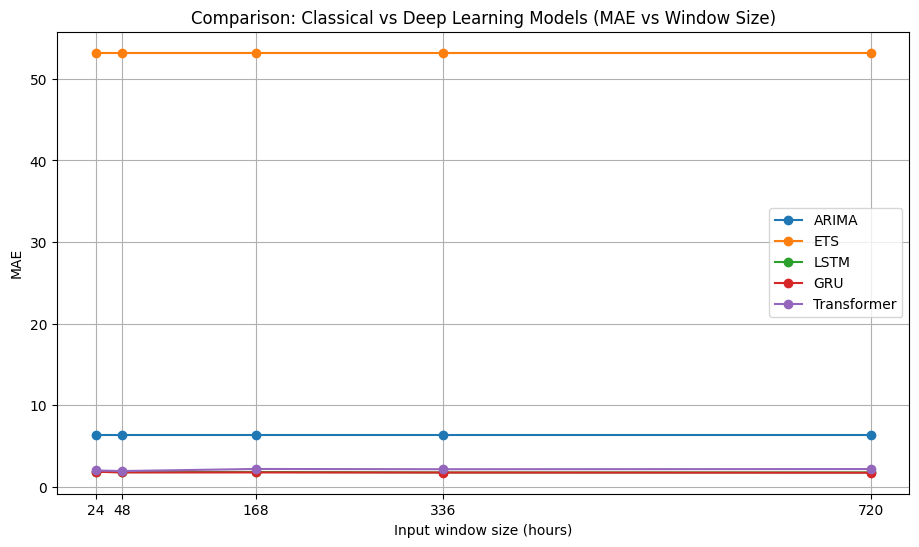

,ARIMA,ETS,LSTM,GRU,Transformer
24,6.272205,53.219884,1.806026,1.813328,1.971265
48,6.272205,53.219884,1.764304,1.732724,1.900096
168,6.272205,53.219884,1.784850,1.729997,2.153417
336,6.272205,53.219884,1.724914,1.718278,2.122636
720,6.272205,53.219884,1.733363,1.693957,2.143205


In [ ]:
# === Combined Plot: ARIMA + ETS + DL (LSTM, GRU, Transformer) ===

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = "/content/model_results"
WINDOW_SIZES = [24, 48, 168, 336, 720]

# Load classical
with open(os.path.join(RESULTS_DIR, "arima_results.json")) as f:
    arima = json.load(f)

with open(os.path.join(RESULTS_DIR, "ets_results.json")) as f:
    ets = json.load(f)

# Load deep learning results
with open(os.path.join(RESULTS_DIR, "deep_results.json")) as f:
    deep = json.load(f)

models = ["ARIMA", "ETS"] + list(deep.keys())
mae_plot = {m: [] for m in models}

for W in WINDOW_SIZES:
    W_str = str(W)

    # ARIMA
    mae_plot["ARIMA"].append(arima.get(W_str, {}).get("mae", np.nan))

    # ETS
    mae_plot["ETS"].append(ets.get(W_str, {}).get("mae", np.nan))

    # Deep models
    for m in deep.keys():
        if W_str in deep[m] and deep[m][W_str]["mae"] is not None:
            mae_plot[m].append(deep[m][W_str]["mae"])
        else:
            mae_plot[m].append(np.nan)

# Plot
plt.figure(figsize=(11,6))

for m in models:
    plt.plot(WINDOW_SIZES, mae_plot[m], marker='o', label=m)

plt.xlabel("Input window size (hours)")
plt.ylabel("MAE")
plt.title("Comparison: Classical vs Deep Learning Models (MAE vs Window Size)")
plt.xticks(WINDOW_SIZES)
plt.grid(True)
plt.legend()
plt.show()

# Table of results
pd.DataFrame(mae_plot, index=WINDOW_SIZES)


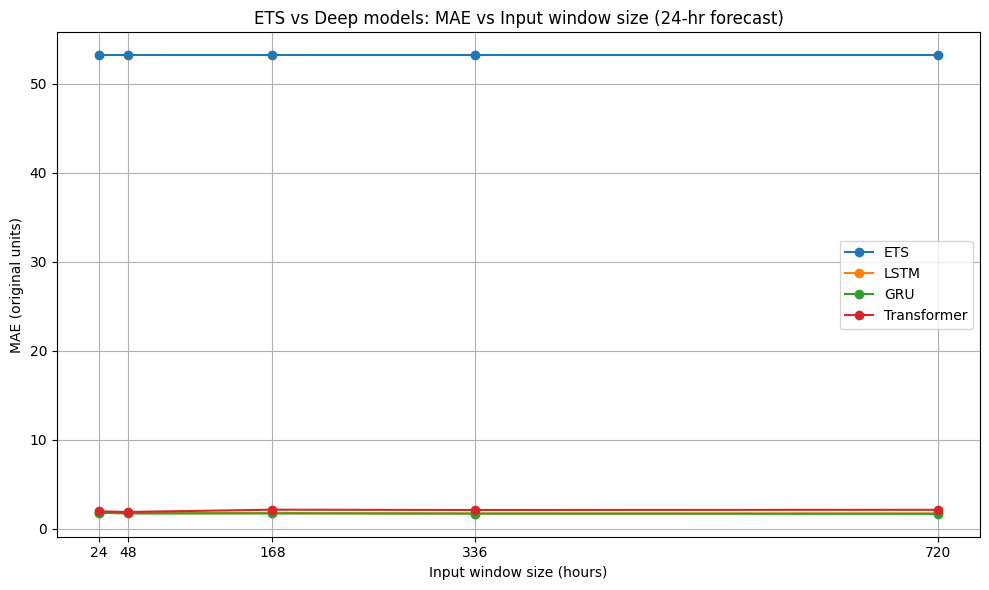

Saved figure to: /content/model_results/ets_vs_deep_mae_vs_window.png


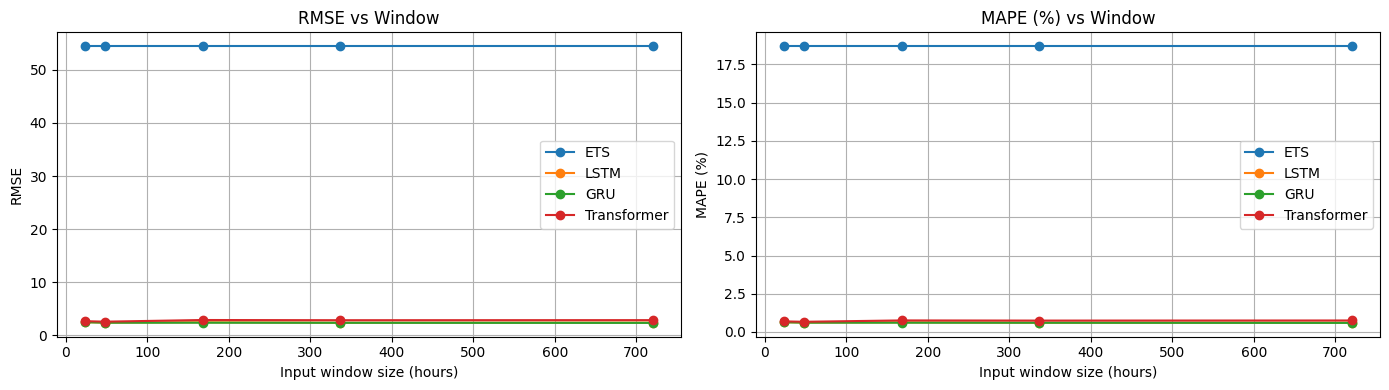

Saved figure to: /content/model_results/ets_vs_deep_rmse_mape.png

MAE (rows = window size):


,ETS,LSTM,GRU,Transformer
24,53.219884,1.806026,1.813328,1.971265
48,53.219884,1.764304,1.732724,1.900096
168,53.219884,1.784850,1.729997,2.153417
336,53.219884,1.724914,1.718278,2.122636
720,53.219884,1.733363,1.693957,2.143205



RMSE (rows = window size):


,ETS,LSTM,GRU,Transformer
24,54.485817,2.423550,2.428131,2.620717
48,54.485817,2.362896,2.329937,2.528186
168,54.485817,2.408019,2.333395,2.842209
336,54.485817,2.327498,2.315412,2.802952
720,54.485817,2.351153,2.298780,2.817783



MAPE% (rows = window size):


,ETS,LSTM,GRU,Transformer
24,18.697636,0.632865,0.635003,0.691323
48,18.697636,0.618084,0.607292,0.665183
168,18.697636,0.624336,0.606785,0.753988
336,18.697636,0.604180,0.602478,0.743696
720,18.697636,0.607272,0.593014,0.750494


Saved metric tables to: /content/model_results


In [ ]:
# === Plot ETS vs Deep Learning (LSTM, GRU, Transformer) ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# paths (update if you used a different directory)
RESULTS_DIR = "/content/model_results"
ETS_PATH = os.path.join(RESULTS_DIR, "ets_results.json")
DEEP_PATH = os.path.join(RESULTS_DIR, "deep_results.json")

WINDOW_SIZES = [24, 48, 168, 336, 720]

# load ETS
if not os.path.exists(ETS_PATH):
    raise FileNotFoundError(f"ETS results not found at {ETS_PATH}. Run the ETS cell first.")
with open(ETS_PATH, "r") as f:
    ets = json.load(f)

# load deep results
if not os.path.exists(DEEP_PATH):
    raise FileNotFoundError(f"Deep-learning results not found at {DEEP_PATH}. Run DL training cells first.")
with open(DEEP_PATH, "r") as f:
    deep = json.load(f)

# prepare data for plotting
models = ["ETS"] + list(deep.keys())
mae_by_model = {m: [] for m in models}
rmse_by_model = {m: [] for m in models}
mape_by_model = {m: [] for m in models}

for W in WINDOW_SIZES:
    key = str(W)
    # ETS
    if key in ets and ets[key] and ets[key].get("mae") is not None:
        mae_by_model["ETS"].append(ets[key]["mae"])
        rmse_by_model["ETS"].append(ets[key]["rmse"])
        mape_by_model["ETS"].append(ets[key]["mape"])
    else:
        mae_by_model["ETS"].append(np.nan)
        rmse_by_model["ETS"].append(np.nan)
        mape_by_model["ETS"].append(np.nan)
    # Deep models
    for m in deep.keys():
        if key in deep[m] and deep[m][key].get("mae") is not None:
            mae_by_model[m].append(deep[m][key]["mae"])
            rmse_by_model[m].append(deep[m][key]["rmse"])
            mape_by_model[m].append(deep[m][key]["mape"])
        else:
            mae_by_model[m].append(np.nan)
            rmse_by_model[m].append(np.nan)
            mape_by_model[m].append(np.nan)

# Plot MAE
plt.figure(figsize=(10,6))
for m in models:
    plt.plot(WINDOW_SIZES, mae_by_model[m], marker='o', label=m)
plt.xlabel("Input window size (hours)")
plt.ylabel("MAE (original units)")
plt.title("ETS vs Deep models: MAE vs Input window size (24-hr forecast)")
plt.xticks(WINDOW_SIZES)
plt.grid(True)
plt.legend()
plt.tight_layout()
out_fig = os.path.join(RESULTS_DIR, "ets_vs_deep_mae_vs_window.png")
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved figure to:", out_fig)

# Also show RMSE and MAPE subplots
fig, axs = plt.subplots(1,2, figsize=(14,4))
for m in models:
    axs[0].plot(WINDOW_SIZES, rmse_by_model[m], marker='o', label=m)
axs[0].set_title("RMSE vs Window")
axs[0].set_xlabel("Input window size (hours)")
axs[0].set_ylabel("RMSE")
axs[0].grid(True)
axs[0].legend()

for m in models:
    axs[1].plot(WINDOW_SIZES, mape_by_model[m], marker='o', label=m)
axs[1].set_title("MAPE (%) vs Window")
axs[1].set_xlabel("Input window size (hours)")
axs[1].set_ylabel("MAPE (%)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
out_fig2 = os.path.join(RESULTS_DIR, "ets_vs_deep_rmse_mape.png")
plt.savefig(out_fig2, dpi=200)
plt.show()
print("Saved figure to:", out_fig2)

# Print tables
df_mae = pd.DataFrame(mae_by_model, index=WINDOW_SIZES)
df_rmse = pd.DataFrame(rmse_by_model, index=WINDOW_SIZES)
df_mape = pd.DataFrame(mape_by_model, index=WINDOW_SIZES)

print("\nMAE (rows = window size):")
display(df_mae)
print("\nRMSE (rows = window size):")
display(df_rmse)
print("\nMAPE% (rows = window size):")
display(df_mape)

# Save tables
df_mae.to_csv(os.path.join(RESULTS_DIR, "ets_vs_deep_mae_table.csv"))
df_rmse.to_csv(os.path.join(RESULTS_DIR, "ets_vs_deep_rmse_table.csv"))
df_mape.to_csv(os.path.join(RESULTS_DIR, "ets_vs_deep_mape_table.csv"))
print("Saved metric tables to:", RESULTS_DIR)


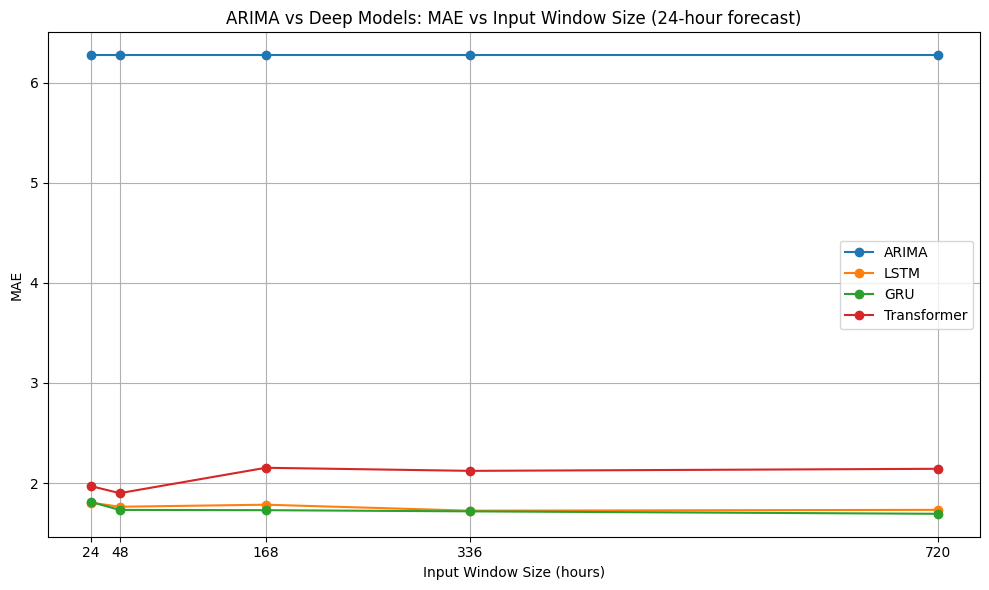

Saved MAE figure to: /content/model_results/arima_vs_deep_mae.png


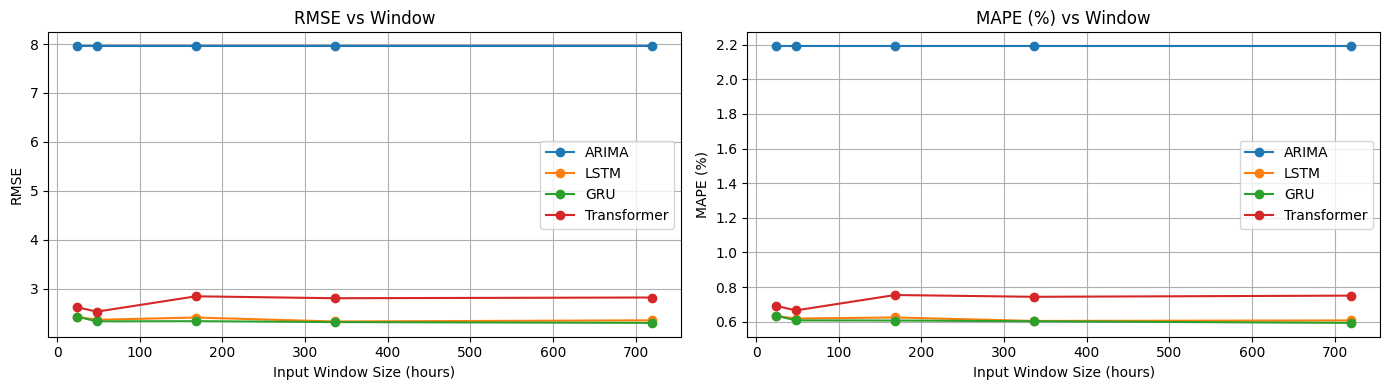

Saved RMSE/MAPE figure to: /content/model_results/arima_vs_deep_rmse_mape.png

MAE Table:


,ARIMA,LSTM,GRU,Transformer
24,6.272205,1.806026,1.813328,1.971265
48,6.272205,1.764304,1.732724,1.900096
168,6.272205,1.784850,1.729997,2.153417
336,6.272205,1.724914,1.718278,2.122636
720,6.272205,1.733363,1.693957,2.143205



RMSE Table:


,ARIMA,LSTM,GRU,Transformer
24,7.956392,2.423550,2.428131,2.620717
48,7.956392,2.362896,2.329937,2.528186
168,7.956392,2.408019,2.333395,2.842209
336,7.956392,2.327498,2.315412,2.802952
720,7.956392,2.351153,2.298780,2.817783



MAPE Table:


,ARIMA,LSTM,GRU,Transformer
24,2.191541,0.632865,0.635003,0.691323
48,2.191541,0.618084,0.607292,0.665183
168,2.191541,0.624336,0.606785,0.753988
336,2.191541,0.604180,0.602478,0.743696
720,2.191541,0.607272,0.593014,0.750494


Saved metric tables to: /content/model_results


In [ ]:
# === ARIMA vs Deep Learning (LSTM, GRU, Transformer) ===

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = "/content/model_results"
ARIMA_PATH = os.path.join(RESULTS_DIR, "arima_results.json")
DEEP_PATH = os.path.join(RESULTS_DIR, "deep_results.json")

WINDOW_SIZES = [24, 48, 168, 336, 720]

# ---- Load ARIMA ----
if not os.path.exists(ARIMA_PATH):
    raise FileNotFoundError("ARIMA results not found. Did you run the ARIMA cell?")

with open(ARIMA_PATH, "r") as f:
    arima = json.load(f)

# ---- Load Deep Learning Results ----
if not os.path.exists(DEEP_PATH):
    raise FileNotFoundError("deep_results.json not found. Run DL training first.")

with open(DEEP_PATH, "r") as f:
    deep = json.load(f)

# Prepare model list
models = ["ARIMA"] + list(deep.keys())

# Metrics storage
mae_by_model = {m: [] for m in models}
rmse_by_model = {m: [] for m in models}
mape_by_model = {m: [] for m in models}

# ---- Fill metrics ----
for W in WINDOW_SIZES:
    key = str(W)

    # ARIMA
    if key in arima and arima[key].get("mae") is not None:
        mae_by_model["ARIMA"].append(arima[key]["mae"])
        rmse_by_model["ARIMA"].append(arima[key]["rmse"])
        mape_by_model["ARIMA"].append(arima[key]["mape"])
    else:
        mae_by_model["ARIMA"].append(np.nan)
        rmse_by_model["ARIMA"].append(np.nan)
        mape_by_model["ARIMA"].append(np.nan)

    # Deep Learning models
    for m in deep.keys():
        entry = deep[m].get(key, None)
        if entry and entry.get("mae") is not None:
            mae_by_model[m].append(entry["mae"])
            rmse_by_model[m].append(entry["rmse"])
            mape_by_model[m].append(entry["mape"])
        else:
            mae_by_model[m].append(np.nan)
            rmse_by_model[m].append(np.nan)
            mape_by_model[m].append(np.nan)

# ========== Plot MAE ==========
plt.figure(figsize=(10,6))
for m in models:
    plt.plot(WINDOW_SIZES, mae_by_model[m], marker='o', label=m)

plt.xlabel("Input Window Size (hours)")
plt.ylabel("MAE")
plt.title("ARIMA vs Deep Models: MAE vs Input Window Size (24-hour forecast)")
plt.xticks(WINDOW_SIZES)
plt.grid(True)
plt.legend()
plt.tight_layout()

out_mae = os.path.join(RESULTS_DIR, "arima_vs_deep_mae.png")
plt.savefig(out_mae, dpi=200)
plt.show()
print("Saved MAE figure to:", out_mae)

# ========== Plot RMSE & MAPE ==========
fig, axs = plt.subplots(1,2, figsize=(14,4))

# RMSE
for m in models:
    axs[0].plot(WINDOW_SIZES, rmse_by_model[m], marker='o', label=m)
axs[0].set_title("RMSE vs Window")
axs[0].set_xlabel("Input Window Size (hours)")
axs[0].set_ylabel("RMSE")
axs[0].grid(True)
axs[0].legend()

# MAPE
for m in models:
    axs[1].plot(WINDOW_SIZES, mape_by_model[m], marker='o', label=m)
axs[1].set_title("MAPE (%) vs Window")
axs[1].set_xlabel("Input Window Size (hours)")
axs[1].set_ylabel("MAPE (%)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
out_rmse_mape = os.path.join(RESULTS_DIR, "arima_vs_deep_rmse_mape.png")
plt.savefig(out_rmse_mape, dpi=200)
plt.show()
print("Saved RMSE/MAPE figure to:", out_rmse_mape)

# ========== Metric Tables ==========
df_mae = pd.DataFrame(mae_by_model, index=WINDOW_SIZES)
df_rmse = pd.DataFrame(rmse_by_model, index=WINDOW_SIZES)
df_mape = pd.DataFrame(mape_by_model, index=WINDOW_SIZES)

print("\nMAE Table:")
display(df_mae)

print("\nRMSE Table:")
display(df_rmse)

print("\nMAPE Table:")
display(df_mape)

# save tables
df_mae.to_csv(os.path.join(RESULTS_DIR, "arima_vs_deep_mae_table.csv"))
df_rmse.to_csv(os.path.join(RESULTS_DIR, "arima_vs_deep_rmse_table.csv"))
df_mape.to_csv(os.path.join(RESULTS_DIR, "arima_vs_deep_mape_table.csv"))

print("Saved metric tables to:", RESULTS_DIR)


In [ ]:
# === Classical Model Evaluation (per window size) ===

def eval_model(forecast_series, ts_full, test_index, W_list):
    out = {}
    for W in W_list:
        y_true_all = []
        y_pred_all = []

        for t in test_index:
            # make sure horizon available
            if t + pd.Timedelta("23H") > test_index.max():
                continue
            # make sure input history exists
            if t - pd.Timedelta(hours=W) < ts_full.index.min():
                continue

            # true y(t : t+23)
            y_true = ts_full.loc[t : t + pd.Timedelta("23H")].values

            # predicted
            try:
                y_pred = forecast_series.loc[t : t + pd.Timedelta("23H")].values
            except:
                continue

            if len(y_pred) == 24:
                y_true_all.append(y_true)
                y_pred_all.append(y_pred)

        if len(y_true_all) == 0:
            out[str(W)] = {"mae": None, "rmse": None, "mape": None}
            continue

        y_true_all = np.vstack(y_true_all).flatten()
        y_pred_all = np.vstack(y_pred_all).flatten()

        mae = np.mean(np.abs(y_true_all - y_pred_all))
        rmse = np.sqrt(np.mean((y_true_all - y_pred_all)**2))
        mape = np.mean(np.abs((y_true_all - y_pred_all) / np.maximum(np.abs(y_true_all), 1e-6))) * 100

        out[str(W)] = {"mae": float(mae),
                       "rmse": float(rmse),
                       "mape": float(mape)}
    return out


# Evaluate each classical model
arima_results = eval_model(arima_pred, ts, test_ts.index, WINDOW_SIZES) if arima_pred is not None else {}
ets_results   = eval_model(ets_pred,   ts, test_ts.index, WINDOW_SIZES) if ets_pred   is not None else {}
auto_results  = eval_model(auto_pred,  ts, test_ts.index, WINDOW_SIZES) if auto_pred  is not None else {}

# Save as JSON
import json
with open(os.path.join(RESULTS_DIR, "arima_results.json"), "w") as f:
    json.dump(arima_results, f)
with open(os.path.join(RESULTS_DIR, "ets_results.json"), "w") as f:
    json.dump(ets_results, f)
with open(os.path.join(RESULTS_DIR, "autoarima_results.json"), "w") as f:
    json.dump(auto_results, f)

print("Saved classical results into /content/model_results/")
print("ARIMA:", arima_results)
print("ETS:", ets_results)
print("AUTOARIMA:", auto_results)


Saved classical results into /content/model_results/
ARIMA: {'24': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '48': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '168': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '336': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}, '720': {'mae': 6.272204564444952, 'rmse': 7.956391587031284, 'mape': 2.1915407016226474}}
ETS: {'24': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '48': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '168': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '336': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}, '720': {'mae': 53.219884359287235, 'rmse': 54.485816848019006, 'mape': 18.697635731288777}}
AUTOARIMA: {'24': {'mae': 8

# TRANSFORMER

In [ ]:
# === Cell 0: Paths & global settings ===
CSV_PATH = "/content/temperature_portland.csv"   # (your uploaded CSV from earlier)
OUT_PREP_DIR = "/content/processed_portland_tft"  # NEW preprocessed data (separate)
RESULTS_DIR = "/content/model_results"            # metrics & preds saved here (existing)
os.makedirs(OUT_PREP_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

WINDOW_SIZES = [24, 48, 168, 336, 720]
HORIZON = 24


In [ ]:
# === Cell 1: Install packages (may take a few minutes) ===
# Run this cell. If it asks to restart runtime after installs, do restart and then re-run the notebook cells (except pip installs).
!pip uninstall -y pytorch-lightning pytorch-forecasting
!pip install -q pytorch-lightning pytorch-forecasting "torch>=1.12" optuna

# Optional: faster training with GPUs if torch cuda is available
import torch
print("Torch version:", torch.__version__, " CUDA available:", torch.cuda.is_available())

Found existing installation: pytorch-lightning 2.5.6
Uninstalling pytorch-lightning-2.5.6:
  Successfully uninstalled pytorch-lightning-2.5.6
Found existing installation: pytorch-forecasting 1.5.0
Uninstalling pytorch-forecasting-1.5.0:
  Successfully uninstalled pytorch-forecasting-1.5.0
Torch version: 2.9.0+cu126  CUDA available: True


In [ ]:
# === Cell 2: Preprocess and create a separate TFT-ready CSV ===
import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

CSV_PATH = "/content/temperature_portland.csv"
OUT_PREP_DIR = "/content/processed_portland_tft"
os.makedirs(OUT_PREP_DIR, exist_ok=True)
OUT_CSV = os.path.join(OUT_PREP_DIR, "tft_input.csv")

# load
df = pd.read_csv(CSV_PATH)
# detect columns (same heuristics used earlier)
datetime_col = None
for c in df.columns:
    if "date" in c.lower() or "time" in c.lower() or "timestamp" in c.lower():
        datetime_col = c
        break
if datetime_col is None:
    datetime_col = df.columns[0]

temp_col = None
for c in df.columns:
    if "temp" in c.lower() or "temperature" in c.lower():
        temp_col = c
        break
if temp_col is None:
    temp_col = df.select_dtypes(include="number").columns[0]

df[datetime_col] = pd.to_datetime(df[datetime_col], infer_datetime_format=True, errors='coerce')
df = df.set_index(datetime_col).sort_index()
# resample hourly and fill
ts = df[temp_col].resample('H').mean().interpolate('time').fillna(method='ffill').fillna(method='bfill')

# Build DataFrame for TFT:
# - time_idx: integer index increasing by 1 per hour from start
# - series_id: single id "series_1"
# - target: temperature
# - known future: hour_of_day, day_of_week (these are allowed as known future inputs)
# - static: none (single series)

df_tft = pd.DataFrame({
    "ds": ts.index,
    "series_id": "series_1",
    "target": ts.values
})
df_tft["time_idx"] = (df_tft["ds"] - df_tft["ds"].min()) // pd.Timedelta(hours=1)
df_tft["time_idx"] = df_tft["time_idx"].astype(int)
df_tft["hour"] = df_tft["ds"].dt.hour
df_tft["day_of_week"] = df_tft["ds"].dt.dayofweek
df_tft["month"] = df_tft["ds"].dt.month
df_tft["is_weekend"] = df_tft["day_of_week"].isin([5,6]).astype(int)

# create some lag features to help TFT (these are "observed values")
# careful: lags will be NaN at the beginning; that's OK
for lag in [1, 24, 168]:
    df_tft[f"lag_{lag}"] = df_tft["target"].shift(lag)

# fill first rows by forward/backfill for lags so model has data (TFT can handle NaNs but this is simpler)
df_tft.fillna(method='bfill', inplace=True)

# Save to new CSV
df_tft.to_csv(OUT_CSV, index=False)
print("Saved preprocessed TFT input to:", OUT_CSV)
print("Rows:", len(df_tft))
df_tft.head()


Saved preprocessed TFT input to: /content/processed_portland_tft/tft_input.csv
Rows: 45253


,ds,series_id,target,time_idx,hour,day_of_week,month,is_weekend,lag_1,lag_24,lag_168
0,2012-10-01 12:00:00,series_1,282.080000,0,12,0,10,0,282.080000,282.08,282.08
1,2012-10-01 13:00:00,series_1,282.080000,1,13,0,10,0,282.080000,282.08,282.08
2,2012-10-01 14:00:00,series_1,282.083252,2,14,0,10,0,282.080000,282.08,282.08
3,2012-10-01 15:00:00,series_1,282.091866,3,15,0,10,0,282.083252,282.08,282.08
4,2012-10-01 16:00:00,series_1,282.100481,4,16,0,10,0,282.091866,282.08,282.08


In [ ]:
# === Cell 3: Create TimeSeriesDataSet helper and dataloaders per window ===
import pandas as pd
import os
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import EncoderNormalizer
from torch.utils.data import DataLoader

OUT_CSV = "/content/processed_portland_tft/tft_input.csv"
df_tft = pd.read_csv(OUT_CSV, parse_dates=["ds"])
df_tft = df_tft.sort_values(["series_id", "time_idx"]).reset_index(drop=True)

# Convert categorical features to string first, then to 'category' dtype
df_tft["hour"] = df_tft["hour"].astype(str).astype("category")
df_tft["day_of_week"] = df_tft["day_of_week"].astype(str).astype("category")
df_tft["month"] = df_tft["month"].astype(str).astype("category")
df_tft["is_weekend"] = df_tft["is_weekend"].astype(str).astype("category")

# Split: same logic as earlier (70/10/20) in time indices
n = len(df_tft)
n_train = int(0.70 * n)
n_val = int(0.10 * n)
# We'll create index boundaries based on number of rows (same chronology)
train_cutoff_time_idx = int(df_tft.loc[n_train-1, "time_idx"])
val_cutoff_time_idx = int(df_tft.loc[n_train + n_val - 1, "time_idx"])

print("train_cutoff_time_idx:", train_cutoff_time_idx, "val_cutoff_time_idx:", val_cutoff_time_idx)

def make_dataloaders(encoder_length, decoder_length, batch_size=64):
    # define dataset
    max_encoder_length = encoder_length
    max_prediction_length = decoder_length

    training_cutoff = train_cutoff_time_idx

    training = TimeSeriesDataSet(
        df_tft[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="target",
        group_ids=["series_id"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_categoricals=["hour", "day_of_week", "month", "is_weekend"],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["target", "lag_1", "lag_24", "lag_168"],
        target_normalizer=GroupNormalizer(groups=["series_id"], transformation="softplus"), # stable scaling
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, df_tft, predict=True, stop_randomization=True)

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    return training, train_dataloader, val_dataloader

# quick smoke test for W=168
training_ds, train_dl, val_dl = make_dataloaders(encoder_length=168, decoder_length=24, batch_size=64)
print("Dataset made. Example batch shapes:")
batch = next(iter(train_dl))
# Access elements of the tuple correctly
print("x (encoder) shape:", batch[0]["encoder_target"].shape, "y shape:", batch[1][0].shape)

train_cutoff_time_idx: 31676 val_cutoff_time_idx: 36201
Dataset made. Example batch shapes:
x (encoder) shape: torch.Size([64, 168]) y shape: torch.Size([64, 24])


In [ ]:
# === Cell 4: Train TFT per window and evaluate (loop) ===
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE, MAPE
import numpy as np
import json
import os

RESULTS_DIR = "/content/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

tft_results = {}

for W in WINDOW_SIZES:
    print("\n=== Training TFT for encoder_length =", W, "decoder_length =", HORIZON, "===\n")
    training, train_dl, val_dl = make_dataloaders(encoder_length=W, decoder_length=HORIZON, batch_size=64)

    # create model (small-ish)
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=3e-3,
        hidden_size=64,  # hidden size / embedding
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=32,
        output_size=HORIZON,  # produce full horizon vector
        loss=MAE(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )

    # trainer with early stopping
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=6, mode="min")
    trainer = Trainer(
        max_epochs=20,
        # Updated Trainer parameters based on deprecation warning
        accelerator='gpu' if DEVICE == 'cuda' else 'cpu',
        devices=1 if DEVICE == 'cuda' else None,
        gradient_clip_val=0.1,
        limit_train_batches=1.0,
        callbacks=[early_stop_callback],
        logger=False,
        enable_progress_bar=True,
    )

    # fit
    trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # Predict on full test range: build a dataloader for prediction
    # We'll build a dataset for prediction that covers the test index and uses the encoder_length W
    # Use TimeSeriesDataSet.from_dataset training with predict=True
    predict_dataset = TimeSeriesDataSet.from_dataset(training, df_tft, predict=True, stop_randomization=True)
    predict_dataloader = predict_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    raw_predictions = tft.predict(predict_dataloader)
    # raw_predictions: pandas DataFrame with columns y_hat.... For multihorizon outputs, pytorch-forecasting returns wide format
    # We'll extract predicted values grouped by "time_idx" and "series_id".

    # The library also provides a helper to get predictions aligned with time indices:
    predictions, x = tft.predict(predict_dataloader, mode="raw", return_x=True)
    # predictions is a dict with keys like 'prediction' etc depending on model. Simpler approach: use tft.predict without raw for tabular
    preds_df = tft.predict(predict_dataloader)  # DataFrame with ds, prediction columns y0..yN sometimes 'prediction' as values
    # The structure: for multi-horizon, columns named "prediction" and "target" for each row representing decoder steps
    # For usability, we will create a time-indexed forecast series: for each row in preds_df, it contains 'prediction' and 'decoder_time_idx' maybe.
    # But to keep things consistent with earlier evaluation, we'll produce 24-step forecasts for each test start time t where we have full horizon.

    # Use TemporalFusionTransformer.predict to obtain pandas with 'prediction' column and 'time_idx' info.
    # preds_df includes columns: "prediction", "time_idx", "series_id", "decoder_target" etc.
    # Filter preds_df rows where 'time_idx' is in test range
    try:
        pf = preds_df.copy()
        # pf contains "time_idx" and "prediction" columns; the 'prediction' column may be an array for horizon; expand it
        if "prediction" in pf.columns and isinstance(pf.loc[0, "prediction"], (list, np.ndarray)):
            # expand
            preds_expanded = pd.DataFrame(pf["prediction"].tolist(), index=pf.index)
            # attach the identifying columns
            for c in ["time_idx", "series_id", "ds"]:
                if c in pf.columns:
                    preds_expanded[c] = pf[c].values
            # Now create forecast series per start time using time_idx as start
            # Convert time_idx back to actual timestamps using df_tft ds min
            ds_min = pd.to_datetime(df_tft["ds"].min())
            # map time_idx to timestamp
            preds_expanded["start_timestamp"] = preds_expanded["time_idx"].apply(lambda x: ds_min + pd.Timedelta(hours=int(x)))
            # for evaluation we will use start_timestamp in test_ts range
        else:
            # fallback: pf may already be in the shape we need
            preds_expanded = pf.copy()
    except Exception as e:
        print("Error while shaping TFT predictions:", e)
        preds_expanded = preds_df.copy()

    # build evaluation arrays: for each start in test_ts index that has W history and full horizon, extract predicted horizon and true horizon
    import numpy as np
    import pandas as pd
    from math import sqrt

    # Build a mapping from start timestamp -> predicted horizon values
    pred_map = {}  # start_timestamp -> predicted array
    # Try to fill pred_map from preds_expanded if 'start_timestamp' exists
    if "start_timestamp" in preds_expanded.columns:
        # columns 0..HORIZON-1 represent horizon values
        horizon_cols = [i for i in preds_expanded.columns if isinstance(i, int) or (isinstance(i, str) and i.isdigit())]
        if len(horizon_cols) == 0:
            # sometimes columns are 0..H-1 as ints
            horizon_cols = [c for c in preds_expanded.columns if isinstance(c, (int, np.integer))]
        # fallback: take first H columns
        if len(horizon_cols) < HORIZON:
            # assume the first H numeric columns are the predictions
            numeric_cols = [c for c in preds_expanded.columns if isinstance(c, (int, np.integer, float, np.floating))]
            horizon_cols = numeric_cols[:HORIZON]
        for _, row in preds_expanded.iterrows():
            try:
                start_ts = pd.to_datetime(row["start_timestamp"])
                pred_vals = row[horizon_cols].values.astype(float)
                if len(pred_vals) >= HORIZON:
                    pred_map[start_ts] = pred_vals[:HORIZON]
            except Exception:
                continue

    # If pred_map is empty, attempt simpler tft.predict raw output handling
    if len(pred_map) == 0:
        # fallback: use tft.predict(predict_dataloader, mode="raw")
        try:
            raw = tft.predict(predict_dataloader, mode="raw")
            # raw is an array [n, horizon]; we need corresponding start timestamps from x["decoder_time_idx"] or x["encoder_time_idx"]
            # This fallback is implementation-dependent and may need further adjustments. We'll try a common pattern:
            # If predictions DataFrame includes 'time_idx' and 'prediction', use that
            dfpred = tft.predict(predict_dataloader)
            if 'prediction' in dfpred.columns and 'time_idx' in dfpred.columns:
                for i, row in dfpred.iterrows():
                    st = pd.to_datetime(row['ds'])
                    val = row['prediction']
                    try:
                        val = np.array(val).astype(float).flatten()[:HORIZON]
                        pred_map[st] = val
                    except Exception:
                        continue
        except Exception as e:
            print("Fallback raw predict failed:", e)

    # Evaluate using pred_map
    y_true_all = []
    y_pred_all = []
    # convert df_tft ds -> index mapping for retrieving true horizon
    ts_series = pd.Series(df_tft['target'].values, index=pd.to_datetime(df_tft['ds']))

    for start_ts in pd.to_datetime(ts_series.index):
        # only test-start timestamps inside test period
        if start_ts < pd.to_datetime(df_tft['ds'].min()):
            continue
    # Instead iterate over actual test timestamps
    test_index = pd.to_datetime(df_tft.loc[df_tft['time_idx'] >= df_tft['time_idx'].iloc[n_train + n_val], 'ds'])
    for t in test_index:
        # require W history
        if (t - pd.Timedelta(hours=W)) < pd.to_datetime(df_tft['ds'].min()):
            continue
        # require full horizon within test bounds
        if (t + pd.Timedelta(hours=HORIZON-1)) > pd.to_datetime(df_tft['ds'].max()):
            continue
        # get prediction
        if t in pred_map:
            y_pred = pred_map[t]
            # get true
            idxs = pd.date_range(t, periods=HORIZON, freq='H')
            y_true = ts_series.loc[idxs].values
            if len(y_pred) == HORIZON:
                y_true_all.append(y_true)
                y_pred_all.append(y_pred)

    # compute metrics
    if len(y_true_all) == 0:
        print(f"No valid predictions found for W={W} (pred_map empty or mismatch). Skipping metric computation.")
        tft_results[W] = {"mae": None, "rmse": None, "mape": None}
    else:
        y_true_all = np.vstack(y_true_all).flatten()
        y_pred_all = np.vstack(y_pred_all).flatten()
        mae = np.mean(np.abs(y_true_all - y_pred_all))
        rmse = np.sqrt(np.mean((y_true_all - y_pred_all)**2))
        denom = np.where(np.abs(y_true_all) < 1e-6, 1e-6, np.abs(y_true_all))
        mape = np.mean(np.abs((y_true_all - y_pred_all) / denom)) * 100.0
        tft_results[W] = {"mae": float(mae), "rmse": float(rmse), "mape": float(mape)}
        print(f"W={W} TFT metrics -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

    # Save predictions & model checkpoint
    np.savez_compressed(os.path.join(RESULTS_DIR, f"tft_preds_W{W}.npz"),
                        y_true=np.array(y_true_all), y_pred=np.array(y_pred_all) if len(y_pred_all)>0 else np.array([]))
    # optionally save the model
    trainer.save_checkpoint(os.path.join(RESULTS_DIR, f"tft_W{W}.ckpt"))

# save results json
with open(os.path.join(RESULTS_DIR, "tft_results.json"), "w") as f:
    json.dump({str(k): v for k, v in tft_results.items()}, f)

print("\nTFT training loop complete. Results saved to", os.path.join(RESULTS_DIR, "tft_results.json"))
print(tft_results)

Device: cuda

=== Training TFT for encoder_length = 24 decoder_length = 24 ===



INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`

In [ ]:
# Try this in place of trainer.fit(...)
try:
    # If TemporalFusionTransformer exposes a lightning wrapper:
    if hasattr(tft, "to_lightning"):
        lm = tft.to_lightning()
        trainer.fit(lm, train_dataloaders=train_dl, val_dataloaders=val_dl)
    elif hasattr(tft, "lightning_module"):
        lm = tft.lightning_module
        trainer.fit(lm, train_dataloaders=train_dl, val_dataloaders=val_dl)
    else:
        # fallback to original call to raise original error (so we know install is needed)
        trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=val_dl)
except Exception as e:
    print("Wrapper attempt failed:", e)
    raise


Wrapper attempt failed: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`

In [ ]:
!pip uninstall -y pytorch-lightning lightning backpack-for-pytorch litmodels
!pip install -q "pytorch-lightning==1.9.6" "pytorch-forecasting==0.11.4" "torch==1.13.1" "torchvision==0.14.1"


Found existing installation: pytorch-lightning 2.5.6
Uninstalling pytorch-lightning-2.5.6:
  Successfully uninstalled pytorch-lightning-2.5.6
Found existing installation: lightning 2.5.6
Uninstalling lightning-2.5.6:
  Successfully uninstalled lightning-2.5.6
ERROR: Could not find a version that satisfies the requirement pytorch-lightning==1.9.6 (from versions: 0.0.2, 0.2, 0.2.2, 0.2.3, 0.2.4, 0.2.4.1, 0.2.5, 0.2.5.1, 0.2.5.2, 0.2.6, 0.3, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.3.4.1, 0.3.5, 0.3.6, 0.3.6.1, 0.3.6.3, 0.3.6.4, 0.3.6.5, 0.3.6.6, 0.3.6.7, 0.3.6.8, 0.3.6.9, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.5.0, 0.5.1, 0.5.1.2, 0.5.1.3, 0.5.2, 0.5.2.1, 0.5.3, 0.5.3.1, 0.5.3.2, 0.5.3.3, 0.6.0, 0.7.1, 0.7.3, 0.7.5, 0.7.6, 0.8.1, 0.8.3, 0.8.4, 0.8.5, 0.9.0, 0.10.0, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.1.6, 1.1.7, 1.1.8, 1.2.0rc0, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.2.4, 1.2.5, 1.2.6,

# Transformer new

In [ ]:
# Cell 1 — settings & imports
import os
os.makedirs("/content/processed_portland_tft", exist_ok=True)
os.makedirs("/content/model_results", exist_ok=True)

CSV_PATH = "/content/temperature_portland.csv"   # your uploaded CSV (path in this session)
OUT_PREP_DIR = "/content/processed_portland_tft"
RESULTS_DIR = "/content/model_results"

WINDOW_SIZES = [24, 48, 168, 336, 720]
HORIZON = 24

import math, json, time, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Cell 2 — preprocessing & save per-window .npz (separate folder)
df = pd.read_csv(CSV_PATH)
# find columns
datetime_col = None
for c in df.columns:
    if "date" in c.lower() or "time" in c.lower() or "timestamp" in c.lower():
        datetime_col = c; break
if datetime_col is None:
    datetime_col = df.columns[0]

temp_col = None
for c in df.columns:
    if "temp" in c.lower() or "temperature" in c.lower():
        temp_col = c; break
if temp_col is None:
    temp_col = df.select_dtypes(include="number").columns[0]

# parse
df[datetime_col] = pd.to_datetime(df[datetime_col], infer_datetime_format=True, errors='coerce')
df = df.set_index(datetime_col).sort_index()
ts = df[temp_col].resample('H').mean().interpolate('time').fillna(method='ffill').fillna(method='bfill')

# build dataframe with time covariates
df_tft = pd.DataFrame({"ds": ts.index, "target": ts.values})
df_tft["time_idx"] = ((df_tft["ds"] - df_tft["ds"].min()) // pd.Timedelta(hours=1)).astype(int)
df_tft["hour"] = df_tft["ds"].dt.hour
df_tft["dow"] = df_tft["ds"].dt.dayofweek
df_tft["month"] = df_tft["ds"].dt.month
df_tft["is_weekend"] = df_tft["dow"].isin([5,6]).astype(int)

# create a train/val/test split (same ratio as earlier pipeline)
n = len(df_tft)
n_train = int(0.70 * n)
n_val = int(0.10 * n)
n_test = n - n_train - n_val
train_df = df_tft.iloc[:n_train].copy()
val_df = df_tft.iloc[n_train:n_train+n_val].copy()
test_df = df_tft.iloc[n_train+n_val:].copy()
print("Train range:", train_df['ds'].min(), "->", train_df['ds'].max())
print("Test range:", test_df['ds'].min(), "->", test_df['ds'].max(), "n_test=", len(test_df))

# fit scaler on train target
scaler = StandardScaler()
scaler.fit(train_df[["target"]].values)
scaler_params = {"mean": float(scaler.mean_[0]), "scale": float(scaler.scale_[0])}
with open(os.path.join(OUT_PREP_DIR, "tft_scaler.json"), "w") as f:
    json.dump(scaler_params, f)
print("Saved scaler params:", scaler_params)

# helper to scale series
def scale_series(arr):
    return (arr - scaler_params["mean"]) / scaler_params["scale"]
def inv_scale(arr):
    return arr * scaler_params["scale"] + scaler_params["mean"]

# convert full series to scaled numpy
full_scaled = scale_series(df_tft["target"].values)

# function to create windows for a given W
def create_windows_from_scaled(series_scaled, W, horizon):
    X, Y, idx = [], [], []  # idx stores start time index (time_idx) for mapping to timestamps
    N = len(series_scaled)
    for t in range(W, N - horizon + 1):
        X.append(series_scaled[t-W:t].astype(np.float32))   # input
        Y.append(series_scaled[t:t+horizon].astype(np.float32))  # target horizon
        idx.append(int(df_tft.loc[t, "time_idx"]))  # store start at time index t
    return np.array(X), np.array(Y), np.array(idx)

# generate and save windows for each W
for W in WINDOW_SIZES:
    X, Y, start_idx = create_windows_from_scaled(full_scaled, W, HORIZON)
    # split into train/val/test based on start_idx: start corresponds to time_idx t which is the first predicted time
    # we want those with start time in train/val/test ranges of df_tft.time_idx
    train_mask = start_idx < df_tft.loc[n_train, "time_idx"] if n_train < len(df_tft) else start_idx < df_tft['time_idx'].iloc[n_train-1]
    # safer approach: use ds timestamps to split
    start_timestamps = df_tft['ds'].iloc[start_idx].values
    # build masks by timestamp
    train_mask = np.array([ts < train_df['ds'].max() for ts in start_timestamps])
    val_mask = np.array([(ts >= train_df['ds'].max()) and (ts < test_df['ds'].min()) for ts in start_timestamps])
    test_mask = np.array([ts >= test_df['ds'].min() for ts in start_timestamps])

    X_train, Y_train = X[train_mask], Y[train_mask]
    X_val, Y_val = X[val_mask], Y[val_mask]
    X_test, Y_test = X[test_mask], Y[test_mask]

    out_file = os.path.join(OUT_PREP_DIR, f"windows_W{W}_H{HORIZON}.npz")
    np.savez_compressed(out_file,
                        X_train=X_train, Y_train=Y_train,
                        X_val=X_val, Y_val=Y_val,
                        X_test=X_test, Y_test=Y_test,
                        start_idx=start_idx)
    print(f"Saved windows for W={W} -> {out_file}   shapes: ", X_train.shape, X_val.shape, X_test.shape)


Train range: 2012-10-01 12:00:00 -> 2016-05-13 08:00:00
Test range: 2016-11-17 22:00:00 -> 2017-11-30 00:00:00 n_test= 9051
Saved scaler params: {'mean': 284.45095538942246, 'scale': 7.307799448736497}
Saved windows for W=24 -> /content/processed_portland_tft/windows_W24_H24.npz   shapes:  (31652, 24) (4526, 24) (9028, 24)
Saved windows for W=48 -> /content/processed_portland_tft/windows_W48_H24.npz   shapes:  (31628, 48) (4526, 48) (9028, 48)
Saved windows for W=168 -> /content/processed_portland_tft/windows_W168_H24.npz   shapes:  (31508, 168) (4526, 168) (9028, 168)
Saved windows for W=336 -> /content/processed_portland_tft/windows_W336_H24.npz   shapes:  (31340, 336) (4526, 336) (9028, 336)
Saved windows for W=720 -> /content/processed_portland_tft/windows_W720_H24.npz   shapes:  (30956, 720) (4526, 720) (9028, 720)


In [ ]:
# Cell 3 — Dataset wrapper
class TFTWindowDataset(Dataset):
    def __init__(self, X, Y):
        # X: (N, W), Y: (N, H)
        self.X = X
        self.Y = Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def get_dataloaders_for_W(W, batch_size=64):
    data = np.load(os.path.join(OUT_PREP_DIR, f"windows_W{W}_H{HORIZON}.npz"))
    X_train, Y_train = data["X_train"], data["Y_train"]
    X_val, Y_val = data["X_val"], data["Y_val"]
    X_test, Y_test = data["X_test"], data["Y_test"]
    train_loader = DataLoader(TFTWindowDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TFTWindowDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TFTWindowDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, (X_test, Y_test)


In [ ]:
# Cell 4 — positional encoding helper
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(0, d_model, 2, dtype=torch.float32)
        div = torch.exp(- (i) * math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x shape (batch, seq_len, d_model)
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)


In [ ]:
# Cell 5 — model definition
class SimpleTFTLike(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2, hidden_dim=128, horizon=HORIZON):
        super().__init__()
        self.seq_len = seq_len
        self.input_proj = nn.Linear(1, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=seq_len+10)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_enc = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)  # pool across sequence
        self.fc = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, horizon)
        )

    def forward(self, x):
        # x: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = self.pos_enc(x)     # add positional encoding
        enc = self.transformer_enc(x)  # (batch, seq_len, d_model)
        # pool: transpose to (batch, d_model, seq_len)
        pooled = self.pool(enc.transpose(1,2)).squeeze(-1)  # (batch, d_model)
        out = self.fc(pooled)  # (batch, horizon)
        return out


In [ ]:
# Cell 6 — training + eval loop
import time
from math import sqrt

def MAE(a,b): return np.mean(np.abs(a-b))
def RMSE(a,b): return np.sqrt(np.mean((a-b)**2))
def MAPE(a,b):
    denom = np.where(np.abs(a) < 1e-6, 1e-6, np.abs(a))
    return np.mean(np.abs((a-b)/denom))*100.0

tft_results = {}

for W in WINDOW_SIZES:
    print(f"\n--- Training TFT-like model for W={W} ---")
    train_loader, val_loader, test_loader, (X_test, Y_test) = get_dataloaders_for_W(W, batch_size=64)
    model = SimpleTFTLike(seq_len=W, d_model=64, nhead=4, num_layers=2, hidden_dim=128, horizon=HORIZON).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # training params
    epochs = 10   # increase for final runs
    best_val = float('inf')
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                out = model(xb)
                val_losses.append(criterion(out, yb).item())
        avg_tr = np.mean(losses) if losses else 0.0
        avg_val = np.mean(val_losses) if val_losses else 0.0
        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
        if ep % max(1, epochs//5) == 0 or ep==1:
            print(f"W{W} Epoch {ep}/{epochs} train_loss={avg_tr:.6f} val_loss={avg_val:.6f}")
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    # Predict on test set in batches
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds.append(out)
    if len(preds) == 0:
        preds_arr = np.empty((0, HORIZON))
    else:
        preds_arr = np.vstack(preds)  # shape (n_test_samples, HORIZON)

    # inverse scale
    y_test_inv = inv_scale(Y_test)  # Y_test is scaled in saved windows
    y_pred_inv = inv_scale(preds_arr)

    # compute metrics (flattened)
    if y_pred_inv.size == 0 or y_test_inv.size == 0:
        tft_results[W] = {"mae": None, "rmse": None, "mape": None}
        print(f"W={W}: no preds produced.")
    else:
        mae = MAE(y_test_inv.flatten(), y_pred_inv.flatten())
        rmse = RMSE(y_test_inv.flatten(), y_pred_inv.flatten())
        mape = MAPE(y_test_inv.flatten(), y_pred_inv.flatten())
        tft_results[W] = {"mae": float(mae), "rmse": float(rmse), "mape": float(mape)}
        print(f"W={W} TFT-like metrics -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

    # save preds & truths
    np.savez_compressed(os.path.join(RESULTS_DIR, f"tft_preds_W{W}.npz"),
                        y_true=y_test_inv, tft=y_pred_inv)
    # save checkpoint
    torch.save(model.state_dict(), os.path.join(RESULTS_DIR, f"tft_W{W}.pth"))

# save results json
with open(os.path.join(RESULTS_DIR, "tft_results.json"), "w") as f:
    json.dump({str(k): v for k, v in tft_results.items()}, f)

print("\nAll TFT-like runs complete. Results saved to", os.path.join(RESULTS_DIR, "tft_results.json"))
print(tft_results)



--- Training TFT-like model for W=24 ---
W24 Epoch 1/10 train_loss=0.206860 val_loss=0.137035
W24 Epoch 2/10 train_loss=0.132336 val_loss=0.131872
W24 Epoch 4/10 train_loss=0.123650 val_loss=0.121309
W24 Epoch 6/10 train_loss=0.119925 val_loss=0.131238
W24 Epoch 8/10 train_loss=0.118288 val_loss=0.125417
W24 Epoch 10/10 train_loss=0.116533 val_loss=0.126778
W=24 TFT-like metrics -> MAE: 1.8526, RMSE: 2.4904, MAPE: 0.65%

--- Training TFT-like model for W=48 ---
W48 Epoch 1/10 train_loss=0.225945 val_loss=0.138977
W48 Epoch 2/10 train_loss=0.131261 val_loss=0.135064
W48 Epoch 4/10 train_loss=0.120780 val_loss=0.120492
W48 Epoch 6/10 train_loss=0.115204 val_loss=0.118494
W48 Epoch 8/10 train_loss=0.112181 val_loss=0.120782
W48 Epoch 10/10 train_loss=0.110888 val_loss=0.124407
W=48 TFT-like metrics -> MAE: 1.8252, RMSE: 2.4355, MAPE: 0.64%

--- Training TFT-like model for W=168 ---
W168 Epoch 1/10 train_loss=0.245469 val_loss=0.139801
W168 Epoch 2/10 train_loss=0.130528 val_loss=0.121347

W=24  MAE=1.8526  RMSE=2.4904  MAPE=0.65%  SMAPE=0.65%  R2=0.9018  MBE=0.2799
W=48  MAE=1.8252  RMSE=2.4355  MAPE=0.64%  SMAPE=0.64%  R2=0.9061  MBE=-0.4718
W=168  MAE=1.8546  RMSE=2.4468  MAPE=0.65%  SMAPE=0.65%  R2=0.9052  MBE=-0.3041
W=336  MAE=1.7965  RMSE=2.4028  MAPE=0.63%  SMAPE=0.63%  R2=0.9086  MBE=0.0508
W=720  MAE=1.9470  RMSE=2.5887  MAPE=0.68%  SMAPE=0.68%  R2=0.8939  MBE=0.0582


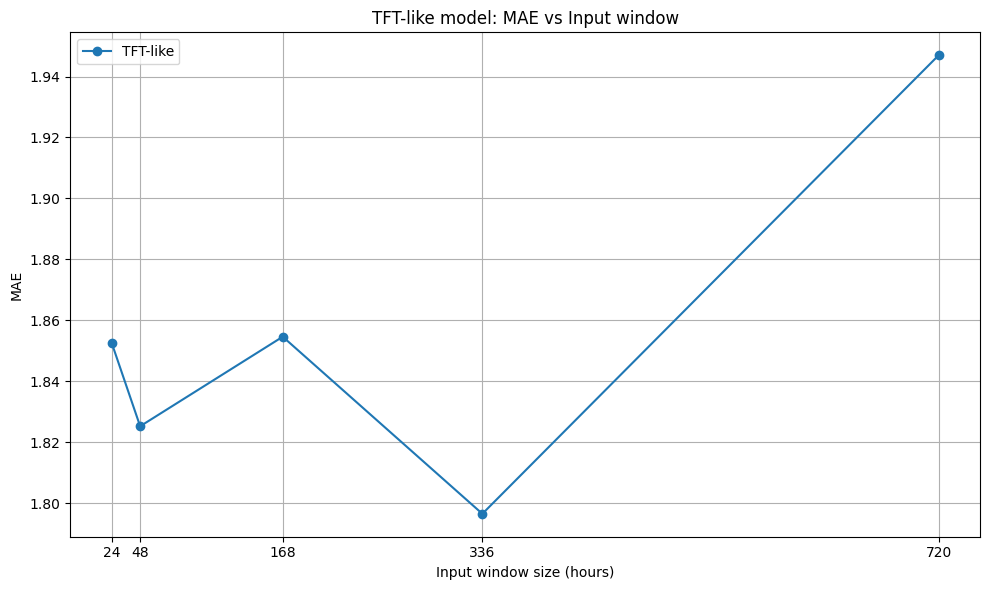

Saved MAE figure to: /content/model_results/tft_mae_vs_window.png


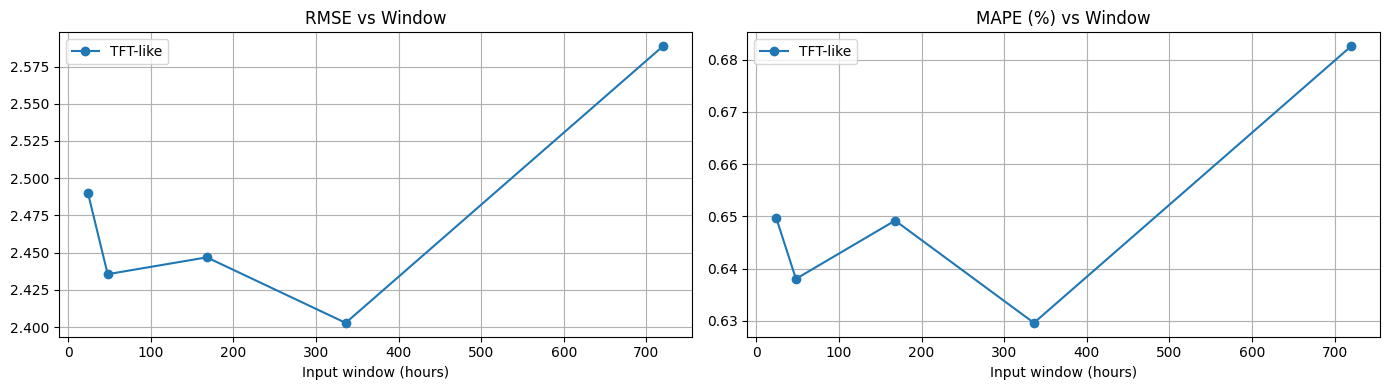

Saved RMSE/MAPE figure to: /content/model_results/tft_rmse_mape.png
Saved full TFT metrics CSV to: /content/model_results/tft_full_metrics.csv

TFT Full Metrics (rows = window size):


,MAE,RMSE,MAPE,SMAPE,R2,MBE
window,,,,,,
24,1.852639,2.490357,0.649765,0.648911,0.901846,0.279917
48,1.825223,2.435510,0.638041,0.639075,0.906121,-0.471755
168,1.854606,2.446817,0.649189,0.649782,0.905248,-0.304051
336,1.796493,2.402782,0.629619,0.629524,0.908628,0.050818
720,1.946979,2.588716,0.682552,0.682418,0.893939,0.058162



Done.


In [ ]:
# === Plot TFT-like transformer results (from /content/model_results) ===
CSV_PATH = "/content/temperature_portland.csv"   # your uploaded CSV (kept for reference)
import os, json, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

RESULTS_DIR = "/content/model_results"
WINDOW_SIZES = [24, 48, 168, 336, 720]

tft_json_path = os.path.join(RESULTS_DIR, "tft_results.json")
if not os.path.exists(tft_json_path):
    raise FileNotFoundError(f"TFT results file not found at {tft_json_path}. Run TFT training first.")

# load per-window summary if present
with open(tft_json_path, "r") as f:
    tft_summary = json.load(f)

# metric helpers
def MAE(y, yhat): return np.mean(np.abs(y - yhat))
def RMSE(y, yhat): return math.sqrt(np.mean((y - yhat)**2))
def MAPE(y, yhat):
    denom = np.where(np.abs(y) < 1e-6, 1e-6, np.abs(y))
    return np.mean(np.abs((y - yhat) / denom)) * 100.0
def SMAPE(y, yhat):
    denom = (np.abs(y) + np.abs(yhat))
    denom = np.where(denom == 0, 1e-6, denom)
    return 100.0 * np.mean(2.0 * np.abs(yhat - y) / denom)
def MBE(y, yhat): return np.mean(yhat - y)
def R2(y, yhat):
    try:
        return float(r2_score(y, yhat))
    except:
        return np.nan

# prepare containers
metrics = {"MAE": [], "RMSE": [], "MAPE": [], "SMAPE": [], "R2": [], "MBE": []}
available_windows = []

# iterate windows, try to load preds file for each
for W in WINDOW_SIZES:
    preds_path = os.path.join(RESULTS_DIR, f"tft_preds_W{W}.npz")
    if not os.path.exists(preds_path):
        # if no preds file, fallback to summary JSON if it contains metrics
        if str(W) in tft_summary and tft_summary[str(W)] is not None:
            s = tft_summary[str(W)]
            metrics["MAE"].append(s.get("mae", np.nan))
            metrics["RMSE"].append(s.get("rmse", np.nan))
            metrics["MAPE"].append(s.get("mape", np.nan))
            metrics["SMAPE"].append(np.nan)
            metrics["R2"].append(np.nan)
            metrics["MBE"].append(np.nan)
            available_windows.append(W)
            continue
        else:
            print(f"Warning: no preds file for W={W} at {preds_path}. Skipping.")
            continue

    # load preds file (expects y_true and tft arrays; adapt if keys differ)
    data = np.load(preds_path, allow_pickle=True)
    # find ground truth
    if 'y_true' in data:
        y_true = np.array(data['y_true'])
    elif 'y' in data:
        y_true = np.array(data['y'])
    else:
        # find first array of appropriate shape
        found = False
        for k in data.files:
            if isinstance(data[k], np.ndarray) and data[k].ndim >= 1:
                y_true = np.array(data[k])
                found = True
                break
        if not found:
            print(f"Could not find y_true in {preds_path}; skipping W={W}.")
            continue

    # find prediction array (key 'tft' used in training cell); adjust if needed
    pred_key = None
    for candidate in ['tft', 'tft_pred', 'pred', 'y_pred', 'preds']:
        if candidate in data.files:
            pred_key = candidate
            break
    if pred_key is None:
        # choose first array that is not y_true (best-effort)
        keys = list(data.files)
        pred_key = next((k for k in keys if k != 'y_true'), None)
    if pred_key is None:
        print(f"No prediction array found in {preds_path}. Keys: {list(data.files)}. Skipping.")
        continue

    y_pred = np.array(data[pred_key])

    # ensure shapes match (N, H)
    try:
        if y_true.ndim == 1:
            # try to reshape if divisible by horizon
            if y_true.size % 24 == 0:
                y_true = y_true.reshape(-1, 24)
            else:
                y_true = y_true.reshape(-1, 1)
        if y_pred.ndim == 1:
            if y_pred.size == y_true.size:
                y_pred = y_pred.reshape(y_true.shape)
            elif y_pred.size % 24 == 0:
                y_pred = y_pred.reshape(-1, 24)
            else:
                # pad or truncate to match shape
                flat = y_pred.flatten()
                if flat.size < y_true.size:
                    flat = np.concatenate([flat, np.full(y_true.size - flat.size, np.nan)])
                y_pred = flat.reshape(y_true.shape)
    except Exception as e:
        print(f"Reshaping error for W={W}: {e}. Skipping.")
        continue

    # flatten and mask NaNs
    yt = y_true.flatten()
    yp = y_pred.flatten()
    mask = ~np.isnan(yt) & ~np.isnan(yp)
    if mask.sum() == 0:
        print(f"No valid predictions for W={W} after masking. Skipping.")
        continue
    yt = yt[mask]
    yp = yp[mask]

    # compute metrics
    mae = MAE(yt, yp)
    rmse = RMSE(yt, yp)
    mape = MAPE(yt, yp)
    smape = SMAPE(yt, yp)
    r2 = R2(yt, yp)
    mbe = MBE(yt, yp)

    metrics["MAE"].append(mae)
    metrics["RMSE"].append(rmse)
    metrics["MAPE"].append(mape)
    metrics["SMAPE"].append(smape)
    metrics["R2"].append(r2)
    metrics["MBE"].append(mbe)
    available_windows.append(W)

    print(f"W={W}  MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%  SMAPE={smape:.2f}%  R2={r2:.4f}  MBE={mbe:.4f}")

# If nothing available
if len(available_windows) == 0:
    raise RuntimeError("No TFT prediction files found. Ensure tft_preds_W{W}.npz exist in /content/model_results/")

# build DataFrames for display (align rows by available_windows)
df_mae = pd.Series(index=available_windows, data=metrics["MAE"], name="MAE")
df_rmse = pd.Series(index=available_windows, data=metrics["RMSE"], name="RMSE")
df_mape = pd.Series(index=available_windows, data=metrics["MAPE"], name="MAPE")
df_smape = pd.Series(index=available_windows, data=metrics["SMAPE"], name="SMAPE")
df_r2 = pd.Series(index=available_windows, data=metrics["R2"], name="R2")
df_mbe = pd.Series(index=available_windows, data=metrics["MBE"], name="MBE")

# Plot MAE
plt.figure(figsize=(10,6))
plt.plot(available_windows, df_mae.values, marker='o', label='TFT-like')
plt.xlabel("Input window size (hours)")
plt.ylabel("MAE")
plt.title("TFT-like model: MAE vs Input window")
plt.xticks(available_windows)
plt.grid(True)
plt.legend()
plt.tight_layout()
out_fig = os.path.join(RESULTS_DIR, "tft_mae_vs_window.png")
plt.savefig(out_fig, dpi=200)
plt.show()
print("Saved MAE figure to:", out_fig)

# Plot RMSE and MAPE subplots
fig, axs = plt.subplots(1,2, figsize=(14,4))
axs[0].plot(available_windows, df_rmse.values, marker='o', label='TFT-like')
axs[0].set_title("RMSE vs Window")
axs[0].set_xlabel("Input window (hours)")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(available_windows, df_mape.values, marker='o', label='TFT-like')
axs[1].set_title("MAPE (%) vs Window")
axs[1].set_xlabel("Input window (hours)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
out_fig2 = os.path.join(RESULTS_DIR, "tft_rmse_mape.png")
plt.savefig(out_fig2, dpi=200)
plt.show()
print("Saved RMSE/MAPE figure to:", out_fig2)

# Save full metrics table CSV
rows = []
for i, W in enumerate(available_windows):
    rows.append({
        "window": int(W),
        "MAE": float(df_mae.loc[W]),
        "RMSE": float(df_rmse.loc[W]),
        "MAPE": float(df_mape.loc[W]),
        "SMAPE": float(df_smape.loc[W]),
        "R2": float(df_r2.loc[W]),
        "MBE": float(df_mbe.loc[W]),
    })
df_all = pd.DataFrame(rows).set_index("window").sort_index()
csv_out = os.path.join(RESULTS_DIR, "tft_full_metrics.csv")
df_all.to_csv(csv_out)
print("Saved full TFT metrics CSV to:", csv_out)

# display tables
print("\nTFT Full Metrics (rows = window size):")
display(df_all)

print("\nDone.")
